In [1]:
import networkx as nx
import numpy as np
import numpy.linalg
import collections
from collections import Counter
from networkx.algorithms import community
import pandas as pd
import math as m
import itertools
import random
from matplotlib.widgets import Slider, Button
from networkx.algorithms import community
import community
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression

In [2]:
def visual_dict(dictionary, label):
    dict2=dict(Counter(dictionary))
    dict2df=pd.DataFrame(dict2.values(), index=dict2.keys(), columns = [label])
    return dict2df.sort_values(by=label, ascending=False).head(5)

# COMPLEX NETWORKS FINAL PRESENTATION

Penny Tarling

Alvaro Vilamarín

Alejandro Hernández

# 1. DATASET

# US AIRPORT DATA 

Complete US airport network in 2010.

The network corresponds to the airports network of flights which have as their departure or destination the US. That includes domestic and international flights.
That means that the nodes of the network are Woldwide airports and the edges are the flight connections of this ariports. The network is weighted by the total amount of passengers between the airports.

This is the network used in the first part of the Why Anchorage is not (that) important: Binary ties and Sample selection-blog post. The data is downloaded from the Bureau of Transportation Statistics (BTS) Transtats site (Table T-100; id 292) with the following filters: Geography=all; Year=2010; Months=all; and columns: Passengers, Origin, Dest.

Based on this, the airport codes are converted into id numbers, and the weights of duplicated ties are summed up. 

While the data contain all US airports and all domestic flights, it only contains Non-US flights that leave or terminate at a US airport and the Non-US airports on the other end of these flights.

Also ties with a weight of 0 are removed (only cargo), and self-loops removed.

# NETWORK OVERVIEW

In [3]:
air_codes = pd.read_csv('USairport_2010_codes.txt', sep=' ', header=None)
air_codes.columns = ['Code', 'Airport']

In [4]:
codes_dic=air_codes.to_dict()

In [5]:
codes=list(air_codes.iloc[:,0])
airport=list(air_codes.iloc[:,1])

In [8]:
G = nx.read_weighted_edgelist(r'USairport_2010.dl')

Number of nodes in the network:

In [9]:
len(G)

1574

Number of edges in the network:

In [14]:
G.number_of_edges()

17214

### Network Extension

Number of Nodes : 1574 

Number of Links : 17214

<center><img src="Map Network.jfif" width=800 height=800>

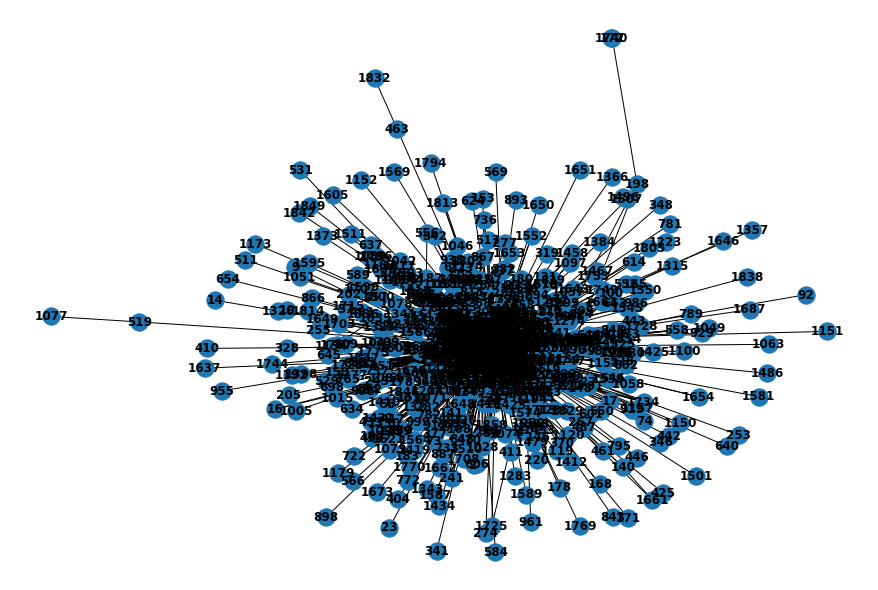

In [97]:
plt.figure(figsize=(12,8)) 
nx.draw(G, with_labels=True, font_weight='bold')

In [16]:
pos_pb = nx.spring_layout(G)

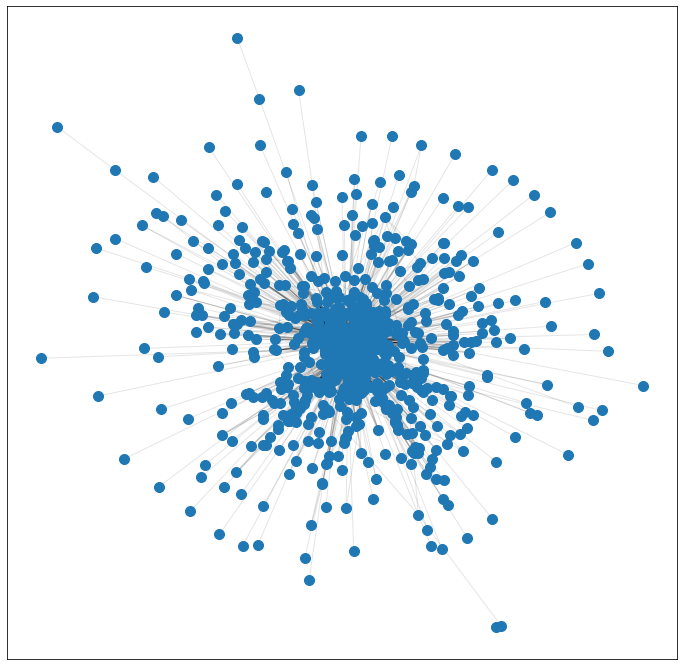

In [17]:
plt.figure(figsize=(12,12))
nodes = nx.draw_networkx_nodes (G , pos = pos_pb, node_size=100)
edges = nx.draw_networkx_edges (G , pos = pos_pb, alpha = 0.1)

### DROP THE 2 DISCONNECTED NODES 

In [19]:
G.remove_node("1155")

NetworkXError: The node 1155 is not in the graph.

In [20]:
G.remove_node("889")

NetworkXError: The node 889 is not in the graph.

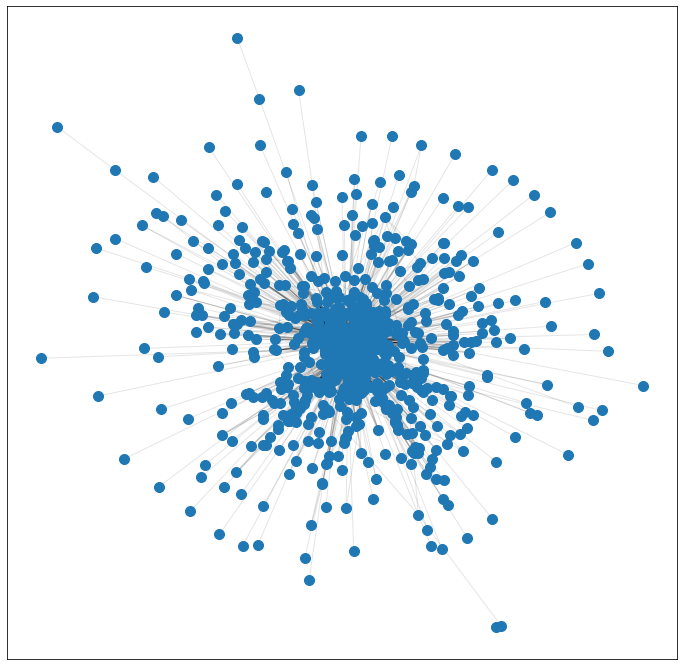

In [21]:
plt.figure(figsize=(12,12))
nodes = nx.draw_networkx_nodes (G , pos = pos_pb, node_size=100)
edges = nx.draw_networkx_edges (G , pos = pos_pb, alpha = 0.1)

#### Let's vary the size of nodes according to degree to better visualise the network and further understand its topology:

In [22]:
d = dict(G.degree())

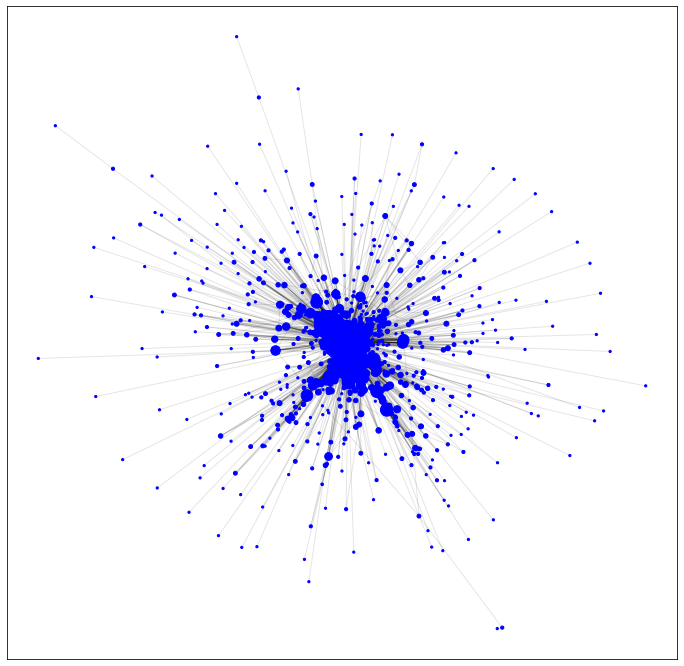

In [23]:
plt.figure(figsize=(12,12))
nodes = nx.draw_networkx_nodes (G , pos = pos_pb, node_size= [n*5 for n in d.values()], 
                               node_color = "b")
edges = nx.draw_networkx_edges (G , pos = pos_pb, alpha = 0.1)

We can see the topology of the network more clearly - there appear to be highly connected central hubs with many peripheral airports.

### Using other external data sources for more contextual information
In order to draw on more contextual information, including airport names and location, we have pulled data from another source matching the global airport codes:

In [24]:
df = pd.read_csv("Airports_new.csv")

In [25]:
G2 = nx.from_pandas_edgelist(df, source='Source', target='Target', )
#Remove disconnected nodes as above
G2.remove_node(1155)
G2.remove_node(889)

In [26]:
d2 = dict(G2.degree())

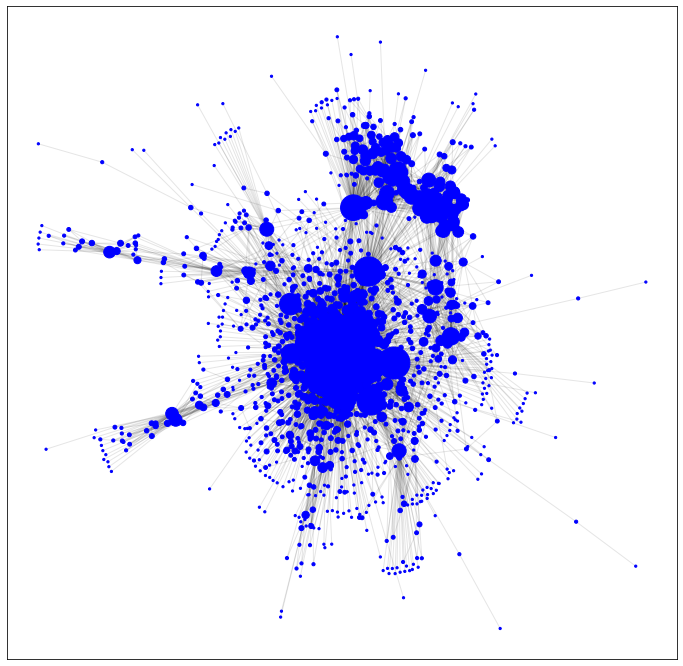

In [27]:
pos_pb2 = nx.spring_layout(G2)
plt.figure(figsize=(12,12))
nodes = nx.draw_networkx_nodes (G2 , pos = pos_pb2, node_size= [n*5 for n in d2.values()], node_color ="b")
edges = nx.draw_networkx_edges (G2 , pos = pos_pb2, alpha = 0.1)

#### Let's add colour to distinguish between the US and international airports:

In [28]:
#Split nodes into US / International / Unknown
US_Airports = []
INT_Airports = []
Unknown = []
for i in range(len(df["US/INT_Source"])):
    if df["US/INT_Source"][i] == "True":
        US_Airports.append(df["Source"][i])
    elif df["US/INT_Source"][i] == "False":
            INT_Airports.append(df["Source"][i])
    else: Unknown.append(df["Source"][i])

In [29]:
Unknown.remove(1155)

In [30]:
US_Airports = set(US_Airports)
INT_Airports = set(INT_Airports)
Unknown = set(Unknown)

In [31]:
#Extract degree for Internatial airports
INT_Airports_list = []
for k in INT_Airports:
    INT_Airports_list.append(k)
    
INT_Airports_degree_list = []
for i in INT_Airports_list:
    INT_Airports_degree_list.append(d2[i])
    
node_size_INT = dict(zip(INT_Airports_list, INT_Airports_degree_list))

In [32]:
#Extract degree for US airports
US_Airports_list = []
for k in US_Airports:
    US_Airports_list.append(k)
    
US_Airports_degree_list = []
for i in US_Airports_list:
    US_Airports_degree_list.append(d2[i])
    
node_size_US = dict(zip(US_Airports_list, US_Airports_degree_list)) 

In [33]:
#Extract degree for Unknown airports
Unknown_Airports_list = []
for k in Unknown:
    Unknown_Airports_list.append(k)
    
Unknown_Airports_degree_list = []
for i in Unknown_Airports_list:
    Unknown_Airports_degree_list.append(d2[i])
    
node_size_Unknown = dict(zip(Unknown_Airports_list, Unknown_Airports_degree_list))

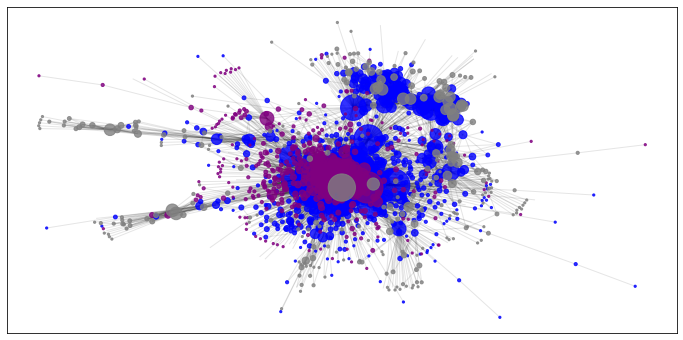

In [144]:
plt.figure(figsize=(12,6))
#draw nodes
nx.draw_networkx_nodes (G2 , with_labels = G2.nodes, pos = pos_pb2, nodelist = US_Airports, node_color = "blue",
                        node_size= [n*5 for n in node_size_US.values()], alpha = 0.8)
nx.draw_networkx_nodes (G2 , with_labels = True, pos = pos_pb2, nodelist = INT_Airports, node_color = "purple",
                        node_size= [n*5 for n in node_size_INT.values()], alpha = 0.8)
nx.draw_networkx_nodes (G2 , pos = pos_pb2, nodelist = Unknown, node_color = "grey", node_size= [n*5 for n in node_size_Unknown.values()],
                       alpha = 0.8, with_labels = True)
#draw edges
nx.draw_networkx_edges (G2 , pos = pos_pb2, alpha = 0.1)
plt.show()

To find the adjacency matrix (to show which nodes a given node is directly connected to):

In [49]:
A = nx.adj_matrix(G)

In [50]:
A.shape

(1572, 1572)

To find the Laplacian matrix:

In [51]:
L = nx.laplacian_matrix(G)

US nodes = Blue  
International nodes = Purple  
Unknown* = Grey  

We can see the central hubs of highly connected US aiports (which is expected given the data only includes flight connections that orginate from or arrive in the US). There seems to be a group of US airports only connected to domestic airports with a handful of highly connected US airports which link these internationally.  

*Unknown - missing airport codes / names from the external database source we found

# 2. MICROSCALE ANALYSIS

#### Characterizing Complex Networks

6/03/20 -13/03/20

- Microscale: role of the nodes
    * Degree
    * Centrality 
    * Global Perspective

Centrality measures help explain the role of a node in a network. There are several different ways to measure centrality:

### DEGREE CENTRALITY

To calculate the degree centrality of each node (how many links each node has normalized by dividing by the maximum possible degree):

In [59]:
DC=nx.degree_centrality(G)

To identify the 10 nodes with highest degree centrality:

In [60]:
DCdict=dict(Counter(DC))
DCdf=pd.DataFrame(DCdict.values(), index=DCdict.keys(), columns = ['Degree Centrality'])
DCdf.sort_values(by='Degree Centrality', ascending=False).head(5)

,Degree Centrality
114,0.199873
709,0.190325
1200,0.188415
877,0.185869
766,0.185232


So, we can see the top 5 nodes that appear in degree centrality correspond to the following airports:

- Atlanta Airport
- Washigtn Dulles Airport
- Chicago Airport 
- LA Airport
- JFK (New York)

So, these nodes correspond to very important big cities of USA, we would expect that these are the most central nodes in this network. 

### - INTERNATIONAL AIRPORTS

Here we show the international airports with the most Degree Centrality

In [65]:
INT_Airports_DC_list = []
for i in INT_Airports_list:
    INT_Airports_DC_list.append(DC2[i])
    
DC_INT = dict(zip(INT_Airports_list, INT_Airports_DC_list)) 

In [66]:
DC_INT_top = dict(Counter(DC_INT).most_common(20))

In [56]:
#Locations = ["Canada", "Canada", "Puerto Rico", "Canada", "Bahamas", "Canada", "Mexico", "Canada", "Mexico", "Canada"]

In [67]:
Locations2 = ["Canada", "Canada", "Puerto Rico", "Canada", "Bahamas", 
              "Canada", "Mexico", "Canada", "Mexico", "Canada", "Canada", "Mexico",
              "Mexico","Jamaica","Dominican Republic","Mexico","UK","Guam","Japan","Virgin Islands"]

In [68]:
df4 = pd.DataFrame()
C2=nx.degree_centrality(G2)
DC2_top = dict(Counter(DC2).most_common(10))
DC_INT_keys = DC_INT_top.keys()

DC_INT_airports = []
for a in DC_INT_keys:
    b = df[df["Source"] == a].index[0]
    DC_INT_airports.append(b)
    
DC_INT_res = []
for a in DC_INT_airports:
    b = df["Airport Name_Source"][a]
    DC_INT_res.append(b)

df4["Degree_Centrality_INT"] = DC_INT_res
df4["Country/Territory"] = Locations2

In [69]:
df4.head(15)

,Degree_Centrality_INT,Country/Territory
0,Lester B. Pearson International Airport,Canada
1,Montreal / Pierre Elliott Trudeau Internationa...,Canada
2,Luis Munoz Marin International Airport,Puerto Rico
3,Vancouver International Airport,Canada
4,Lynden Pindling International Airport,Bahamas
5,Calgary International Airport,Canada
6,Canc√∫n International Airport,Mexico
7,Edmonton International Airport,Canada
8,Licenciado Benito Juarez International Airport,Mexico
9,Ottawa Macdonald-Cartier International Airport,Canada


#### Where do Americans travel most to? Which international locations is the US most widely connected to (tourist / personal and business travel)?

Canada, Mexico.... Should be careful about ruining relationship with Mexico!

We can see from the previous table some of the most important airports that have a realtionship to and from the US. 
In the top airports we can see they are from cities where there is a great exchange of business or even tourism coming or going from United States like Toronto, Montreal, Puerto Rico, Cancún, Bahamas, etc.

### CLOSENESS

To compute closeness centrality (average distance from a given node to all other nodes, normalised by the sum of minimum possible distances):

In [53]:
CC=nx.closeness_centrality(G)

To identify the 10 nodes with highest closeness centrality:

In [54]:
CCdict=dict(Counter(CC))
CCdf=pd.DataFrame(CCdict.values(), index=CCdict.keys(), columns = ['Closeness'])
CCdf.sort_values(by='Closeness', ascending=False).head(5)

,Closeness
114,0.498414
877,0.495271
1068,0.494803
389,0.490631
709,0.490019


- Atlanta Airport
- Los Angeles Airport
- Minneapolis Airport 
- Denver International Airport
- Washington Airport

### BETWEENESS

To compute betweenness centrality (measure of the influence of a node over the flow of information between every pair of ndoes):

In [55]:
BC=nx.betweenness_centrality(G)

To identify the 10 nodes with highest betweenness centrality:

In [100]:
BCdict=dict(Counter(BC))
BCdf=pd.DataFrame(BCdict.values(), index=BCdict.keys(), columns = ['Betweenness'])
BCdf.sort_values(by='Betweenness', ascending=False).head(5)

,Betweenness
88,0.216678
505,0.091312
877,0.057989
766,0.057766
1016,0.052829


- Alska Airport (Ted Stevens)
- Alaska Airport (Fairbanks)
- Los Angeles Airport 
- JFK Airport New York
- Miami Airport

In [57]:
EBC=nx.edge_betweenness_centrality(G)

To identify the 10 edges with highest betweenness centrality:

In [58]:
dict(Counter(EBC).most_common(10))

{('47', '88'): 0.020685357573105825,
 ('70', '1433'): 0.015679189344025263,
 ('88', '1016'): 0.012181240414250128,
 ('505', '114'): 0.010756361814047216,
 ('1822', '921'): 0.010497841305615188,
 ('505', '766'): 0.010327720047409016,
 ('505', '877'): 0.00979081106682239,
 ('679', '88'): 0.009733303981797444,
 ('1240', '802'): 0.009656138443379422,
 ('88', '709'): 0.009602555593835735}

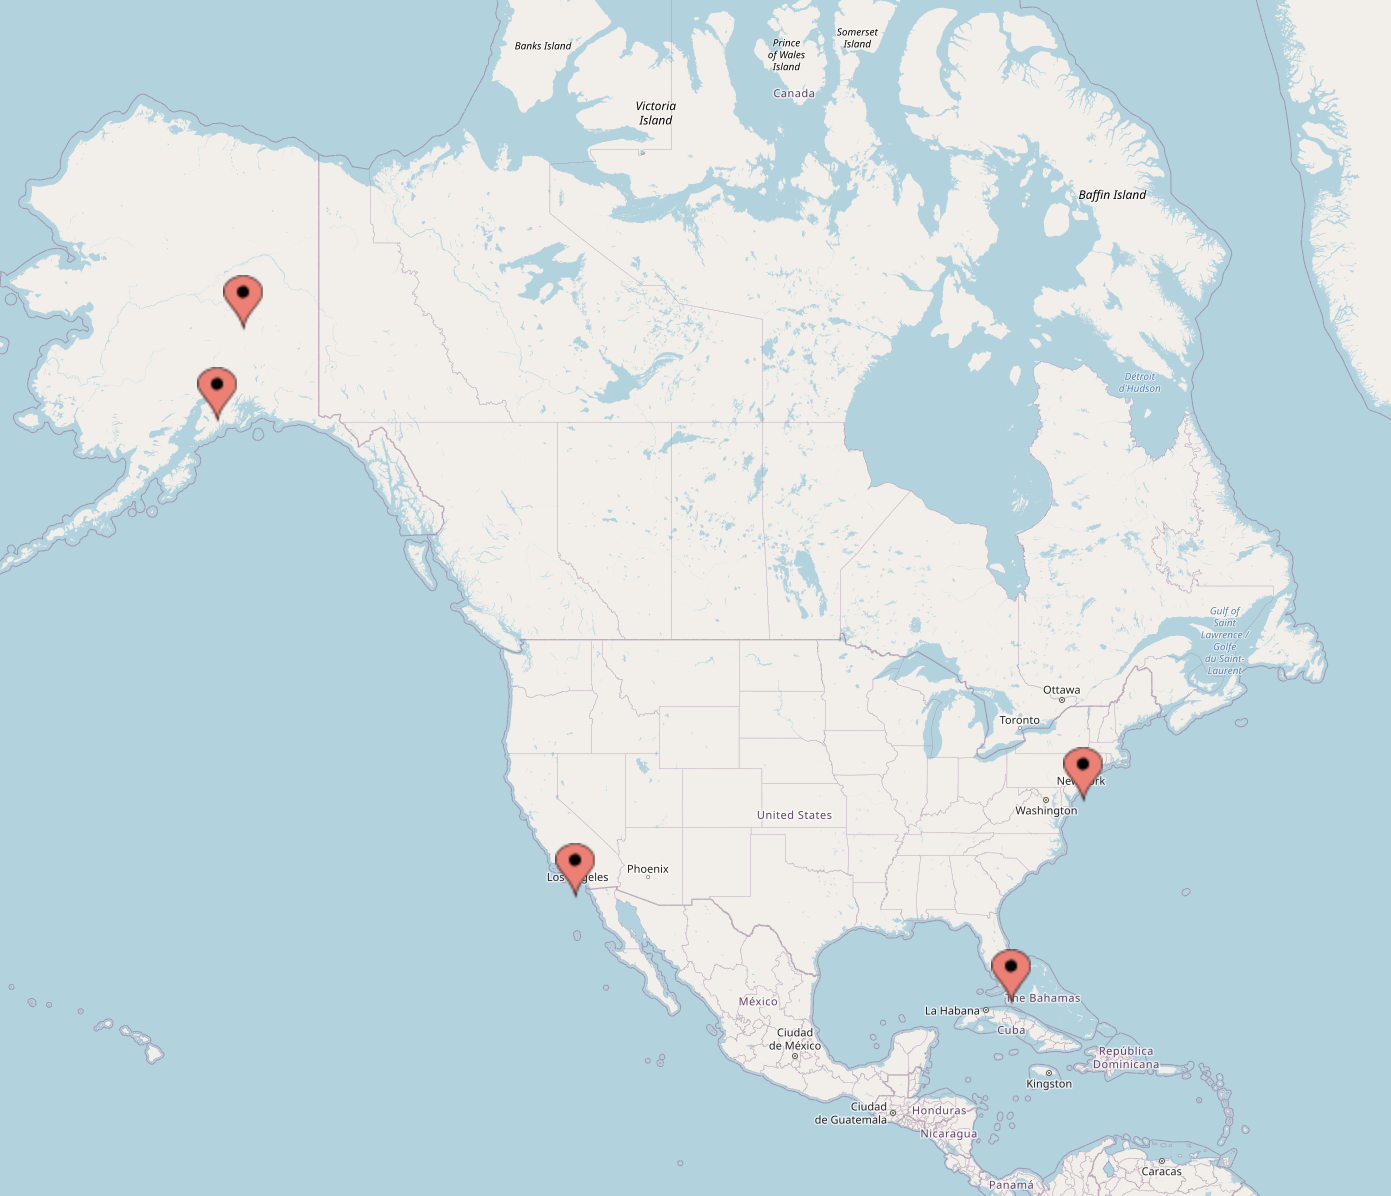

In [98]:
from IPython.display import Image
Image(filename = "BC_airports.png", width =400, height=400)

Map displaying the 5 airports with highest Betweenness Centrality score. It makes sense that these airports are located in the 4 corners of the US as they will be connecting hubs for international destinations. They nearly represent the most eastern, western, southern and northern locations allowing for shortest internation flight paths. 

New York and Los Angeles are the two largest cities in the US by population so it makes sense that they would have airports with high connectivity. Miami airport plays a crucial role connecting Central and South America to the US and the rest of the world. 

Interestingly two of the top 5 aiports are in Alaska. This suggests the importance of the US's oil industry, largely based in Alaska as well as the prevalence of remote US milatary stations, which will be connected via these two airports

### EIGENVECTOR CENTRALITY

To find the eigenvector_centrality of each node (the importance of each node based on the importance of nodes it is connected to).

High Eigenvector centrality identifies nodes that are surrounded by other nodes with high eigenvector centrality. This measure helps to locate groups of interconnected nodes with high prestige.

In [59]:
E_CT=nx.eigenvector_centrality(G)

To identify the 10 nodes with highest eigenvector centrality score:

In [60]:
ECTdict=dict(Counter(E_CT))
ECTdf=pd.DataFrame(ECTdict.values(), index=ECTdict.keys(), columns = ['EigenCentrality'])
ECTdf.sort_values(by='EigenCentrality', ascending=False).head(5)

,EigenCentrality
1200,0.118255
114,0.115400
435,0.115028
709,0.113259
1068,0.113093


- Chicago Airport
- Atlanta Airport
- Detroit Airport
- Washignton Airport
- Minneapolis Airport

### KATZ CENTRALITY

To find Katz centrality (relative influence of a node within a network by measuring the number of the immediate neighbours and also all other nodes in the network that connect to the node under consideration through these immediate neighbors):

In [61]:
KATZ_C_np=nx.katz_centrality_numpy(G)

To identify the 10 nodes with highest KATZ centrality score:

In [62]:
dict(Counter(KATZ_C_np).most_common(10))

{'875': 0.1546897698679366,
 '1411': 0.1395981799314392,
 '452': 0.12172791487668684,
 '1374': 0.11710084114165452,
 '246': 0.11522522249242716,
 '435': 0.1147590697964279,
 '344': 0.11467998496944361,
 '731': 0.10987708706247055,
 '1462': 0.1071432274155859,
 '1611': 0.09696102713538016}

In [66]:
visual_dict(KATZ_C_np, 'Katz Centrality')

,Katz Centrality
875,0.154690
1411,0.139598
452,0.121728
1374,0.117101
246,0.115225


- Las Vegas Airport
- Indiana Airport
- Northwest Florida Beaches (Florida)
- Virginia Airport
- Baltimore 

### PAGE RANK

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links

In [145]:
PR=nx.pagerank(G)

In [146]:
visual_dict(PR, 'PageRank')

,PageRank
114,0.036593
1200,0.028053
877,0.026305
389,0.023930
391,0.023101


- Atlanta Airport
- Chicago Airport
- Minneapolis Airport 
- Denver International Airport
- Dallas Fort Airport

### CLUSTERING

Clustering corresponds to the measure of prevalence of triangles in an egocentric network. 

The transitivity ratio and the clustering coefficient are the two most popular statistics that measure the number of triangles in a network.

First, we compute the number of triangles that include a node as one vertex.

In [69]:
TRIANGLES=nx.triangles(G)

In [70]:
visual_dict(TRIANGLES, 'Triangles')

,Triangles
1200,9442
435,9110
114,9036
1068,8822
709,8755


#### A comparison between the centrality measures

In the next table we show the summary results of the centrality measure for the US Airports

In [71]:
#Create dataframe to store centrality measures
Centrality_measures = pd.DataFrame(index = ["1","2","3","4","5","6","7","8","9","10"])

# Degree centrality
DC2=nx.degree_centrality(G2)
DC2_top = dict(Counter(DC2).most_common(10))
DC2_keys = DC2_top.keys()

DC2_airports = []
for a in DC2_keys:
    b = df[df["Source"] == a].index[0]
    DC2_airports.append(b)
    
Degree_Centrality = []
for a in DC2_airports:
    b = df["Airport Name_Source"][a]
    Degree_Centrality.append(b)

Centrality_measures["Degree_Centrality"] = Degree_Centrality
Centrality_measures.head()

#Closeness centrality
CC2=nx.closeness_centrality(G2)
CC2_top = dict(Counter(CC2).most_common(10))
CC2_keys = CC2_top.keys()

CC_airports = []
for a in CC2_keys:
    b = df[df["Source"] == a].index[0]
    CC_airports.append(b)
    
CC_Centrality = []
for a in CC_airports:
    b = df["Airport Name_Source"][a]
    CC_Centrality.append(b)

Centrality_measures["Closeness_Centrality"] = CC_Centrality
Centrality_measures.head()

#Betweeness centrality
BC2=nx.betweenness_centrality(G2)
BC2_top = dict(Counter(BC2).most_common(10))
BC2_keys = BC2_top.keys()

BC2_airports = []
for a in BC2_keys:
    b = df[df["Source"] == a].index[0]
    BC2_airports.append(b)
    
Betweeness_Centrality = []
for a in BC2_airports:
    b = df["Airport Name_Source"][a]
    Betweeness_Centrality.append(b)

Centrality_measures["Betweenness_Centrality"] = Betweeness_Centrality
Centrality_measures.head()

#Eigenvector centrality
E_CT2=nx.eigenvector_centrality(G2)
E_CT2_top = dict(Counter(E_CT2).most_common(10))
E_CT2_keys = E_CT2_top.keys()

E_CT2_airports = []
for a in E_CT2_keys:
    b = df[df["Source"] == a].index[0]
    E_CT2_airports.append(b)
    
Eigenvector_Centrality = []
for a in E_CT2_airports:
    b = df["Airport Name_Source"][a]
    Eigenvector_Centrality.append(b)

Centrality_measures["Eigenvector_Centrality"] = Eigenvector_Centrality
Centrality_measures.head()

#Katz centrality
KATZ2=nx.katz_centrality_numpy(G2)
KATZ2_top = dict(Counter(KATZ2).most_common(10))
KATZ2_keys = KATZ2_top.keys()

KATZ2_airports = []
for a in KATZ2_keys:
    b = df[df["Source"] == a].index[0]
    KATZ2_airports.append(b)
    
KATZ_Centrality = []
for a in KATZ2_airports:
    b = df["Airport Name_Source"][a]
    KATZ_Centrality.append(b)

Centrality_measures["Katz_Centrality"] = KATZ_Centrality
Centrality_measures.head()

#Page rank centrality
PR2=nx.pagerank(G2)
PR2_top = dict(Counter(PR2).most_common(10))
PR2_keys = PR2_top.keys()

PR_airports = []
for a in PR2_keys:
    b = df[df["Source"] == a].index[0]
    PR_airports.append(b)
    
PR_Centrality = []
for a in PR_airports:
    b = df["Airport Name_Source"][a]
    PR_Centrality.append(b)

Centrality_measures["Page_Rank"] = PR_Centrality


In [70]:
Centrality_measures.head()

,Degree_Centrality,Closeness_Centrality,Betweenness_Centrality,Eigenvector_Centrality,Katz_Centrality,Page_Rank
1,Hartsfield Jackson Atlanta International Airport,Hartsfield Jackson Atlanta International Airport,Ted Stevens Anchorage International Airport,Chicago O'Hare International Airport,McCarran International Airport,John F Kennedy International Airport
2,Washington Dulles International Airport,Los Angeles International Airport,Fairbanks International Airport,Hartsfield Jackson Atlanta International Airport,South Bend Regional Airport,Los Angeles International Airport
3,Chicago O'Hare International Airport,Minneapolis-St Paul International/Wold-Chamber...,Los Angeles International Airport,Detroit Metropolitan Wayne County Airport,Northwest Florida Beaches International Airport,Miami International Airport
4,Los Angeles International Airport,Denver International Airport,John F Kennedy International Airport,Washington Dulles International Airport,Roanoke‚ÄìBlacksburg Regional Airport,Westchester County Airport
5,John F Kennedy International Airport,Washington Dulles International Airport,Miami International Airport,Minneapolis-St Paul International/Wold-Chamber...,Baltimore/Washington International Thurgood Ma...,Ted Stevens Anchorage International Airport


[Conclusion]

#### Table showing the top 5 airports with highest Degree, Closeness, Betweeness, Eigenvector, Katz and Page Rank centrality scores

Whilst there is certainly overlap between these centrality measures, there are also differences as well. Particularly regarding Katz centrality

Further explanation....



[PT - PAGE_RANK - THIS IS THE ONLY ONE THAT IS DIFFERENT USING G NETWORK. WHY? WHICH SHOULD WE KEEP?] 

*Node clustering measure was not included in table because many nodes have clustering coefficient of 1 

#### Correlation between centrality measures

As we can see from the diagrams of the two example networks below, similar or contrasting results for the centrality metrics can give us insight to the topology of the network.

As we can see from the diagrams of the two example networks below, similar or contrasting results for the centrality metrics can give us insight to the topology of the network.

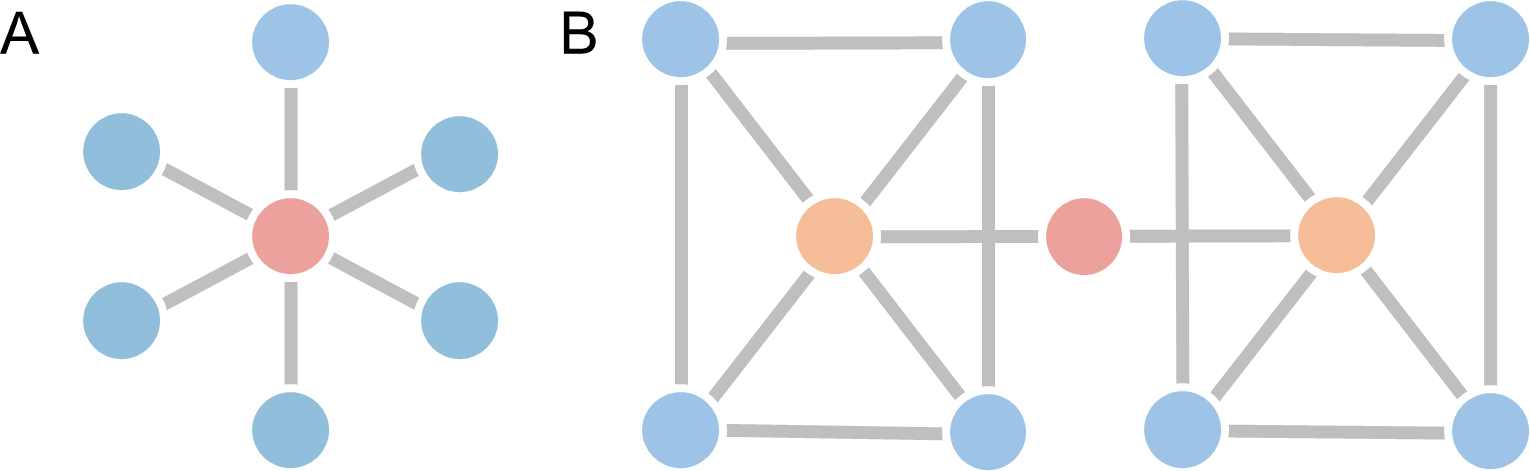

In [73]:
from IPython.display import Image
Image(filename = "Comparison_of_centrality_measures.png", width =400, height=400)

"Panel A shows an example of a star network. The red node has maximal degree (greatest number of connections), closeness (is a short distance from other nodes) and betweenness (lies on many shortest-paths between nodes) in this network. In this case these three centrality measures are perfectly concordant. Panel B shows a network in which centrality measures are not concordant. The red node has the highest betweenness and closeness, but it has the lowest degree in the network" 

*Image and explanation credit to: Consistency and differences between centrality measures across distinct classes of networks. Stuart Oldham ,Ben Fulcher,Linden Parkes,Aurina Arnatkevic̆iūtė,Chao Suo,Alex Fornito*

We calculated the Spearman correlation coefficient between our centrality metrics. This is the same method used by Oldham et al, assuming that the metrics may be non-linearly correlated

In [74]:
CLUSTERING2=nx.clustering(G2)

In [75]:
s = DC2.values()
t = CC2.values()
u = BC2.values()
v = E_CT2.values()
w = KATZ2.values()
x = PR2.values()
y = CLUSTERING2.values()

In [76]:
s1 = np.array(list(s))
t1 = np.array(list(t))
u1 = np.array(list(u))
v1 = np.array(list(v))
w1 = np.array(list(w))
x1 = np.array(list(x))
y1 = np.array(list(y))

In [77]:
headings = ["Degree", "Closeness", "Betweeness", "Eigenvector","Katz", "Page Rank","Clustering"]

In [78]:
from scipy.stats import spearmanr

centralities = [s1, t1, u1, v1, w1, x1, y1]
corr = []
for a in centralities:
    for b in centralities:
        c,_ = spearmanr(a, b)
        corr.append(round(c,2))

reshaped = np.array(corr).reshape(7,7)

In [79]:
df3 = pd.DataFrame(reshaped,index = headings,columns = headings)
df3.style.set_properties(**{'width':'7em'})\
        .set_table_styles([d])

,Degree,Closeness,Betweeness,Eigenvector,Katz,Page Rank,Clustering
Degree,1,0.73,0.85,0.67,-0.02,0.94,0.3
Closeness,0.73,1,0.57,0.95,0,0.53,0.28
Betweeness,0.85,0.57,1,0.5,-0.02,0.87,-0.07
Eigenvector,0.67,0.95,0.5,1,0.04,0.44,0.24
Katz,-0.02,0,-0.02,0.04,1,-0.03,0
Page Rank,0.94,0.53,0.87,0.44,-0.03,1,0.2
Clustering,0.3,0.28,-0.07,0.24,0,0.2,1


#### Table showing the Spearman correlation score between different centrality measures

[PT - DISCUSS WITH TEAM.... ]
Understanding topology of network: Eigen_vector and cloesness very correlated... why?
Betweeness and closeness not that correlated why?
Clustering and degree - not correlated - makes sense both peripheral nodes and ones with high degree likely to have low clustering coefficient....



If the measures are highly correlated, then the development of multiple measures may be somewhat redundant and we can expect the different measures to behave similarly in statistical analyses. On the other hand, if the measures are not highly correlated, they indicate distinctive measures likely to be associated with different outcomes.

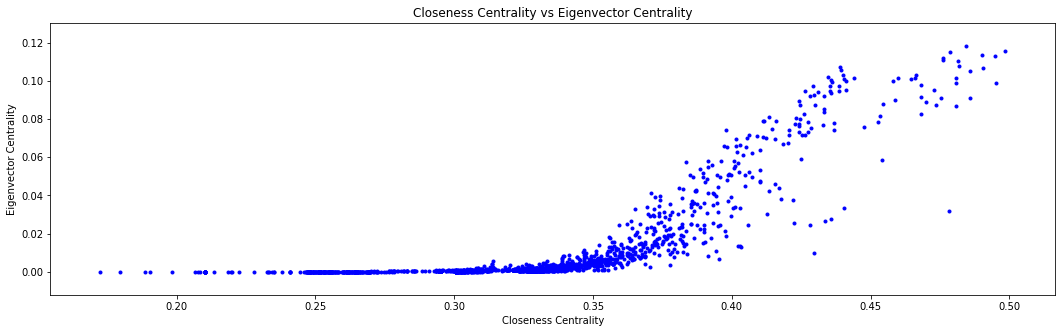

In [96]:
fig, ax = plt.subplots(figsize=(18,5))
plt.scatter(t, v, color='b', label = 'actual', marker = '.', linewidths = 1)

plt.title("Closeness Centrality vs Eigenvector Centrality")
plt.ylabel("Eigenvector Centrality")
plt.xlabel("Closeness Centrality")
#plt.legend(loc='upper right');
plt.show()

[PT - could plot more scatter plots? ]

### GLOBAL CLUSTERING METRICS

### TRANSIVITY

The transitivity coefficient of a network, is the ratio of the number of loops of length three and the number of paths of length two. Hence, it is the frequency of loops of length three in the network.

In [169]:
TRANSITIVITY=nx.transitivity(G)

In [170]:
TRANSITIVITY

0.38414344664491556

For weighted graphs, the clustering used here is defined as the geometric average of the subgraph edge weights.

### CLUSTERING

In [120]:
CLUSTERING=nx.clustering(G , weight="a")

In [ ]:
dict(Counter(CLUSTERING).most_common(35))

In [128]:
len(list(nx.non_edges(G)))

1217592

All these nodes that have a clustering coefficient of 1 participate in every possible triangle involving any pair of its neighbors. 

In [129]:
DG = list(dict(G.degree()).values())
DG.sort()
clist= list(CLUSTERING.values())
clist.sort()

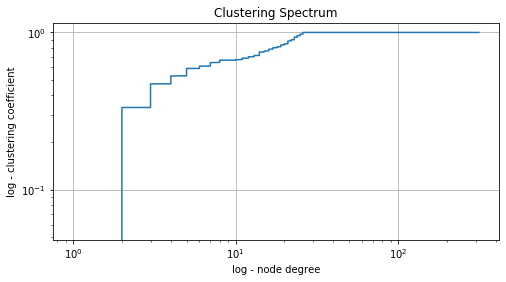

In [131]:
plt.figure(figsize=(8,4))
plt.loglog(DG, clist)
plt.ylabel('log - clustering coefficient')
plt.xlabel('log - node degree')
plt.title('Clustering Spectrum')
plt.grid()
plt.show()

Compute the average clustering coefficient for the graph G. Which give us an idea of the general clustering coefcicient of the network.

In [132]:
AVERAGE_CLUSTERING=nx.average_clustering(G, count_zeros=True)

In [133]:
AVERAGE_CLUSTERING

0.5047939546538639

As we see there exist a difference between the clustering and the transitivity coefficients, but they give us a clue  on the number of triangles our network has.

#### Investigating clustering coeffiecient further:

The clustering coefficient seems high. We will investigate this further below:

First let's order the nodes by clustering coefficient so we can understand the nature of the network better

In [ ]:
{k: v for k, v in reversed(sorted(CLUSTERING.items(), key=lambda item: item[1]))}

In [22]:
#Number of nodes with clustering coefficient = 1
sum(value == 1 for value in CLUSTERING.values())

288

In [23]:
#Number of nodes with clustering coefficient = 0
sum(value == 0 for value in CLUSTERING.values())

386

There are 288 nodes (out of 1572) with clustering coefficent (CC) of 1 which seems high.
But also 386 nodes with clustering coefficient 0 - this makes sense as we know there are many peripheral airports only connected to one other airport. 

Let's look into those nodes with CC = 1

In [110]:
#Randomly choose node with clustering coeff = 1
A = G.edges("750")
A

EdgeDataView([('750', '114'), ('750', '526'), ('750', '709'), ('750', '500'), ('750', '766'), ('750', '1200'), ('750', '1437')])

In [111]:
B = list(A)
B

[('750', '114'),
 ('750', '526'),
 ('750', '709'),
 ('750', '500'),
 ('750', '766'),
 ('750', '1200'),
 ('750', '1437')]

Node 750 is connected to 7 other airports. In order for it's CC to be 1, these airports all need to be connected to each other. We will check this below:

In [112]:
C = []
for i in B:
    C.append(i[1])

In [113]:
C

['114', '526', '709', '500', '766', '1200', '1437']

In [114]:
import itertools

List all possible combination of edges between the neighbours of 750:

In [115]:
D = list(itertools.combinations(C, 2))
D

[('114', '526'),
 ('114', '709'),
 ('114', '500'),
 ('114', '766'),
 ('114', '1200'),
 ('114', '1437'),
 ('526', '709'),
 ('526', '500'),
 ('526', '766'),
 ('526', '1200'),
 ('526', '1437'),
 ('709', '500'),
 ('709', '766'),
 ('709', '1200'),
 ('709', '1437'),
 ('500', '766'),
 ('500', '1200'),
 ('500', '1437'),
 ('766', '1200'),
 ('766', '1437'),
 ('1200', '1437')]

Check to see if there is an edge between all neighbours:

In [116]:
E = []
for i in range(len(D)):
    E.append(G.has_edge(D[i][0], D[i][1]))
    
len(E)

21

There are 21 possible combinations of edges between the 7 neighbours (6+5+4+3+2+1). We can see above (function returns "True") that there is an edge connecting all these neighbours 

Below are the list of aiports in this cluster. Istanbul is the starting node and as we can see, its neighbours are all large international airports across USA. It makes sense that all these airports are connected to each other.

750 = IST Istanbul  
114 = ATL Atlanta, Georgia    
526 = FLL Fort Lauderdale, Florida   
709 = IAD Dulles, Virginia   
500 = EWR Newark, New York   
766 = JFK, New York   
1200 = ORD, Chicago O'Hare, Illinois  
1437 = SFO, San Francisco, California

There are 2 NY airports in the list however which do not appear to have passenger flights between them (from internet search). We have checked these nodes separately below and they are definitely connected in the network data. There is an airport shuttle that goes between these two airports so we believe this is what the edge represents in the network. 

In [124]:
G.has_edge("766","500")

True

In [125]:
G.get_edge_data('766','500')

{'weight': 148.0}

Below we have built a function so we can easily check the CC of other nodes in the network

In [136]:
def check_cluster(node):
    A = G.edges(node)
    B = list(A)
    C = []
    for i in B:
        C.append(i[1])
        D = list(itertools.combinations(C, 2))
    E = []
    for i in range(len(D)):
        E.append(G.has_edge(D[i][0], D[i][1]))
    
    return E

For example check node 86 (Amsterdam Airport) which we think has CC of 0.994. We can see this is true because it has 26 neighbours and there are 349 edges between neighbours out of a possible 351. The neighbours will all be international US airports (because the network only includes passenger flights that arrive or leave the US) so it makes sense that the 26 large international airports in the US will all be connected to each other.

In [137]:
A = (check_cluster("86"))

In [138]:
A.count(True) / len(A)

0.9943019943019943

From our tests, we believe that there are in fact 288 airports in our network with CC = 1 and many others with very high CC, so we can believe the overall network CC of 0.5.

Particularly as some of the nodes with high CC have a relatively large degree (e.g 750 and 86) adding more to the total number of possible triangles (which are in fact triangles). These will outweigh the nodes in the network with a with CC = 0 but also only have degree 0 so only contributing a low number of possible triangles (even though these are not complete triangles). 

### SHORTEST PATH

We compute shortest paths in the graph.

In [185]:
SP=nx.shortest_path(G)

In [191]:
A_SP=nx.all_shortest_paths(G, "1832","1077")

In [194]:
SPL=nx.shortest_path_length(G)

We return the average shortest path length, once we have deleted the 2 isolated nodes.

In [195]:
ASPL=nx.average_shortest_path_length(G)
ASPL

3.1151638395019137

We can show that a path exist between 2 different nodes.

In [196]:
HAS_PATH=nx.has_path(G,"1832","1077")
HAS_PATH

True

Or that a path doesn't exist

In [198]:
HAS_PATH=nx.has_path(G,"1155","1077")
HAS_PATH

False

# 3. MACROSCALE ANALYSIS


13/03/20 to 20/03/20

* Shortest-path
* Clustering
* Distributions  (degree, betweenness)
* Statistical Properties: Clustering
* Correlations

### DISTANCE MEASURES

The $\textbf{center}$ is the set of nodes with eccentricity equal to the radius

In [202]:
CENTER = nx.center(G)

CENTER

['709', '1837']

The network has two central nodes, 709 node corresponds to the IAD airport (Washington Dulles International Airport) and 1837 node to the YYZ airport (Toronto Pearson Airport). These are two large, busy airports with many flights going in and out and connected to many other aiports. Therefore requiring the minimum distance to reach any other airport in the network. Interestingly, one of these nodes is in Canada not the US. This may be explained because airports with highest traffic in the US will not have passenger flights to other airports in the same city thus increasing the number of flights needed to reach any other airpots from these nodes. 

Node 709 is also in the top 10 nodes for highest eigenvector centrality score and traingle measure (see above). It is expectect that the airport with the minimum longest path to reach any other airport is also connected directly to other highly connected airports (high eigenvector centrality score) and also forms lots of traingles with pairs of airports which can all be travelled directly between.

The $\textbf{eccentricity}$ of a node v is the maximum distance from v to all other nodes in G

In [99]:
ECCENTRICITY = nx.eccentricity(G) #v, sp

In [100]:
visual_dict(ECCENTRICITY, 'Eccentricity')

,Eccentricity
377,8
454,8
558,8
413,8
912,8


The $\textbf{radius}$ is the minimum eccentricity

In [204]:
RADIUS = nx.radius(G) #e

RADIUS

4

This means the maximum distance, number of paths, to any other aiport from the two center nodes is $\textbf{4}$

The $\textbf{diameter}$ is the maximum eccentricity

In [205]:
DIAMETER = nx.diameter(G) #e

DIAMETER

8

It therefore takes a maximum of 8 flights to travel from any two airports in the network, but this is based on a passenger travelling within or back to the US for each flight (the data does not include flights between airports outside the US, only to and from US and domestic flights).

The $\textbf{periphery}$ is the set of nodes with eccentricity equal to the diameter

In [206]:
PERIPHERY = nx.periphery(G) #e

PERIPHERY

['1740',
 '277',
 '454',
 '558',
 '912',
 '377',
 '413',
 '1126',
 '1288',
 '833',
 '789',
 '1731',
 '1119',
 '1373',
 '1496',
 '1726',
 '1745',
 '1854',
 '1856']

There are 19 airports where it takes a maximum of 8 flights to reach any other airport in the network. Some of these airports are:

- Westerly State Airport, Whashington (1740)
- Chena Hot Springs, Alaska (277)
- Edna Bay Seaplane Base, Alaska (454)
- The Farmville Regional Airport, Virginia (558)

It is clear that these are isolated and small airports, and it makes sense that they are peripehiric nodes of the network.

$\textbf{Dijkstra path}$ returns the shortest path from source to target in a weighted graph G

In [207]:
#Test the two center nodes
DIJKSTRA_PATH_709_to_1837 = nx.dijkstra_path(G, source = "709", target = "1837")

DIJKSTRA_PATH_709_to_1837

['709', '1221', '1837']

Shortest distance between two central nodes is 2 edges (i.e. two seperate flights) via 1 other airport which is a surprising result given we would expect two of the main airports in the dataset to have direct flights (providing they are not in the same city). This result is because the network is weighted and weights correspond to the number of flights between each airport. This command will calculate the shortest path considering the values of the weights. It is possible to fly directly from node 709 to node 1837 (as expected between two key US airports) but there were >78,000 flights between these airports in 2010 resulting in a high weighted edge. See below:

In [208]:
#(A) Weight between two central nodes
edge_709_1837 = G.get_edge_data("709","1837")
edge_709_1837

{'weight': 78844.0}

In [209]:
#(B) weights between shortest path between two central nodes
edge_709_1221 = G.get_edge_data("709","1221")
edge_1221_1837 = G.get_edge_data("1221","1837")
print(edge_709_1221)
print(edge_1221_1837)

{'weight': 1.0}
{'weight': 2.0}


Therefore 

(A) total weight from 709 --> 1837 = 78,844

(B) total weight from 709 --> 1221 --> 1837 = 3

So that's why in DIJKSTRA_PATH algorithm above calculates shortest path as route B as total weight is much smaller. 

In [210]:
#Test center to a periphery
DIJKSTRA_PATH_709_to_1731 = nx.dijkstra_path(G, source = "709" , target = "1731")

DIJKSTRA_PATH_709_to_1731

['709', '403', '1847', '156', '847', '1855', '705', '846', '1731']

Distance between central node and a peripheral node is much longer 8 edges, via 7 other nodes. However again this result is not very meaningful because it is based on the weights of the edges. 

In [211]:
#Test distance between two peripheral nodes
DIJKSTRA_PATH_1740_to_1731 = nx.dijkstra_path(G, source = "1740" , target = "1731")

DIJKSTRA_PATH_1740_to_1731

['1740',
 '172',
 '198',
 '1221',
 '709',
 '403',
 '1847',
 '156',
 '847',
 '1855',
 '705',
 '846',
 '1731']

Distance between these two selected peripheral nodes is 12, via 11 other nodes, including one of the central nodes 709. But again, the command takes into consideration the weights of the edges so does not correspond to the most direct route. 

### CLUSTERING

Compute the $\textbf{squares clustering coefficient}$ for nodes. For each node, it will return the fraction of possible squares that exist at that node

In [150]:
SQUARE_CLUSTERING = nx.square_clustering(G)

### ASSORTATIVITY
$\textbf{Degree Assortativity:}$ measures the similarity of connections in the graph with respect to the node degree

In [213]:
DEGREE_ASSORTATIVITY_COEFF = nx.degree_assortativity_coefficient(G) # x,y

DEGREE_ASSORTATIVITY_COEFF

-0.11340155515827592

$\textbf{Attribute}$: Assortativity measures the similarity of connections in the graph with respect to the given attribute

In [ ]:
ATTRIBUTE_ASSORTATIVITY_COEFF = nx.attribute_assortativity_coefficient(G, attribute = ) #attribute

ATTRIBUTE_ASSORTATIVITY_COEFF

The nodes do not have attributes so this command is not relevant 

$\textbf{Numeric}$: Assortativity measures the similarity of connections in the graph with respect to the given numeric attribute.

In [ ]:
NUMERIC_ASSORTATIVITY_COEFF = nx.numeric_assortativity_coefficient(G, attribute = )

The nodes do not have attributes so this command is not relevant 

$\textbf{Degree}$: Assortativity measures the similarity of connections in the graph with respect to the node degree (same as above but faster computation)

In [216]:
DEGREE_PEARSON_CORRELATION_COEFF = nx.degree_pearson_correlation_coefficient(G)

DEGREE_PEARSON_CORRELATION_COEFF

-0.11340155515827605

In terms of correlation, we can observe that our network has a slight negative Pearson correlation coefficient with a r = -0.1134. As we can see  the Assortativity Coefficient is near 0, so we can say that the network is near being a non-assortative. The fact that this value is negative small value means that high degree nodes are slightly more likely to be connected to low degree nodes.

We find that it makes sense as there are lots of small airports connected to the central nodes (and many more nodes with a small degree). 

### AVERAGE DEGREE NEIGHBOR

Returns the average degree of the neighborhood of each node

In [139]:
AVERAGE_NEIGHBOR_DEGREE = nx.average_neighbor_degree(G)

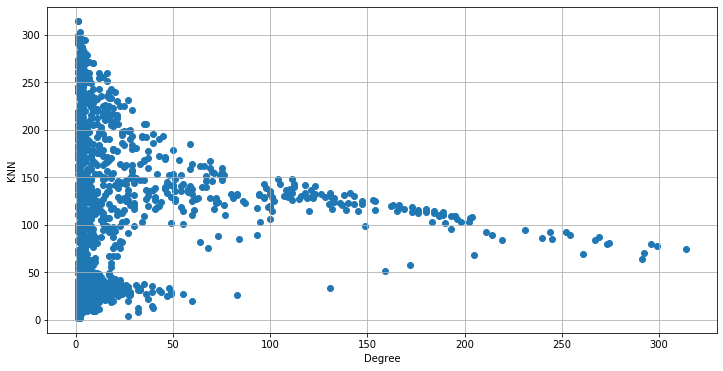

In [140]:
AND = list(dict(AVERAGE_NEIGHBOR_DEGREE).values())
degree_list = list(dict(G.degree()).values())

plt.figure(figsize=(12,6))
plt.scatter(degree_list, AND)
plt.ylabel('KNN')
plt.grid()
plt.xlabel('Degree')
plt.show()

The 3 airports with more neighborhood degree are: Fortaleza International Airport (538), Aeroporto de Belgrado-Nikola Tesla (150), ANR Robinson International Airport (1555).

# 4. MODELS

### DEGREE DISTRIBUTION

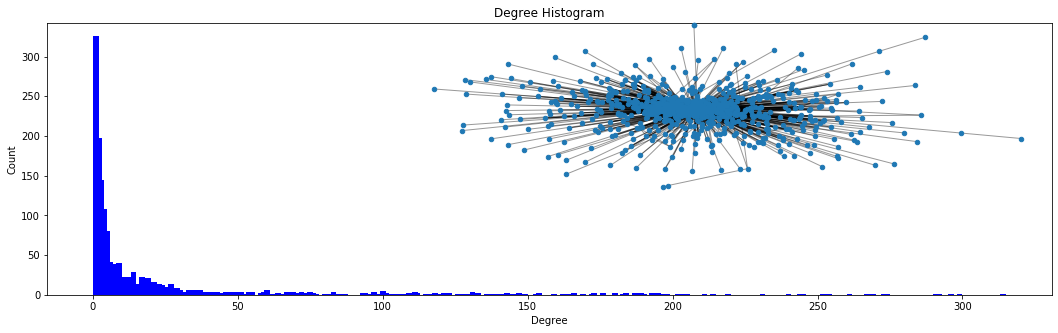

In [96]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots(figsize=(18,5))
plt.bar(deg, cnt, width=2.0, color='b')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

#draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()

We can see from the histogram that the majority of nodes have a small degree. In particular, 326 nodes have degree = 1 and 197 nodes have degree = 2. So roughly one third of all nodes are only connected to 1 or 2 other nodes. However, there are a small group of nodes at the centre of the network with a high degree: 23 nodes have a degree of >200. With the highest degree of 314.

This is reflective of an passenger flight network between airports. There are some airports in the US which will be connected to lots of other domestic and international airports (23 airports in our database have passenger flights to over 200 aiports). But the majority of airports will be small and remote with limited traffic and access. The airports which are highly connected will likely be connected to each other, giving this network one central hub.

### DEGREE RANK PLOT

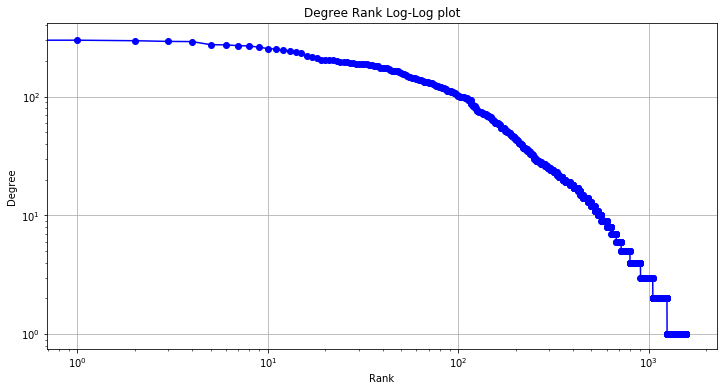

In [92]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

dmax = max(degree_sequence)

fig, ax = plt.subplots(figsize=(12, 6))
plt.loglog(degree_sequence, 'b-', marker='o')
plt.grid()
plt.title("Degree Rank Log-Log plot")
plt.ylabel("Degree")
plt.xlabel("Rank")

plt.show()

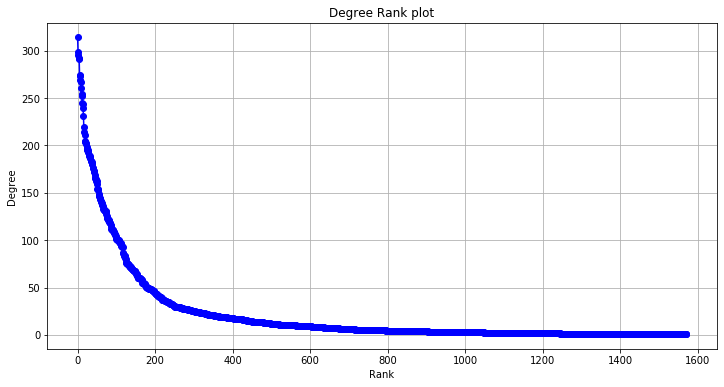

In [93]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

dmax = max(degree_sequence)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(degree_sequence, 'b-', marker='o')
plt.title("Degree Rank plot")
plt.grid()
plt.ylabel("Degree")
plt.xlabel("Rank")

plt.show()

Again, by examining the degree-rank (loglog) plot we can see that several nodes only have degree 1 (horizontal step bottom right), several nodes have degrees of 2, 3, 4, 5, 6 although fewer at each step. We can then see a smooth curve showing there are many nodes with degree size 10 to 100 evenly distributed within this range. Above degree size of 100, the distribution begins to spread out until we reach a maximum degree size of 314.

Also, the plot could be fitted to a negative exponential function, although not definitive exponential since it does not decrease as fast as a negative exponential.



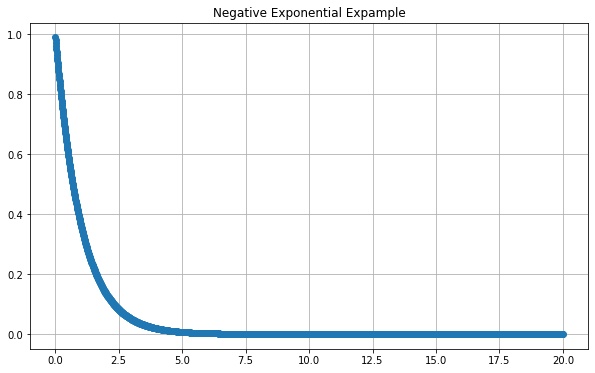

In [152]:
plt.figure(figsize=(10,6))
t = np.arange(0.01, 20.0, 0.01)
plt.title('Negative Exponential Expample')
plt.plot(t, np.exp(-t), marker='o')
plt.grid()
plt.show()

In [110]:
cnt_prob = []
for i in cnt:
    cnt_prob.append(i / len(G))

In [111]:
k_ave = sum(degree_sequence)/len(G)
deg_to_100 = []
for i in range(1,101):
    deg_to_100.append(i)
pois_prob = []
for k in deg_to_100:
    pois_prob.append((m.exp(-k_ave)) * (k_ave**k/(m.factorial(k))))

In [112]:
gamma = 2
deg_to_300 = []
for i in range(2,301):
    deg_to_300.append(i)
pow_law_prob = []
for k in deg_to_300:
    pow_law_prob.append(k**(-gamma))

### Poisson and power law to model degree distribution

To explore how the network relates to other given models, we have calculated the probability P(k) of randomly selecting a node in the network with k degree and plotted P(k) against k. This is similar to the histogram plot above but plotting probablity instead of count. 

This has been plotted below with a Poisson Degree Distribution, with the average k being directly calculated from our distribution (total degree / total number of nodes = 21), so the models can be compared. As N (total number of nodes) is large, >1000, it is appropriate to consider a Poisson. 

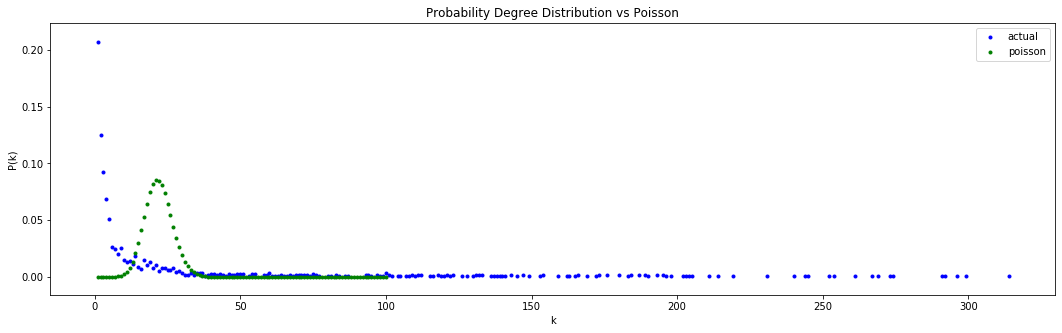

In [113]:
fig, ax = plt.subplots(figsize=(18,5))
plt.scatter(deg, cnt_prob, color='b', label = 'actual', marker = '.', linewidths = 1)
plt.scatter(deg_to_100, pois_prob, color = 'g', label = 'poisson', linewidths = 1, marker = '.')

plt.title("Probability Degree Distribution vs Poisson")
plt.ylabel("P(k)")
plt.xlabel("k")
plt.legend(loc='upper right');
plt.show()

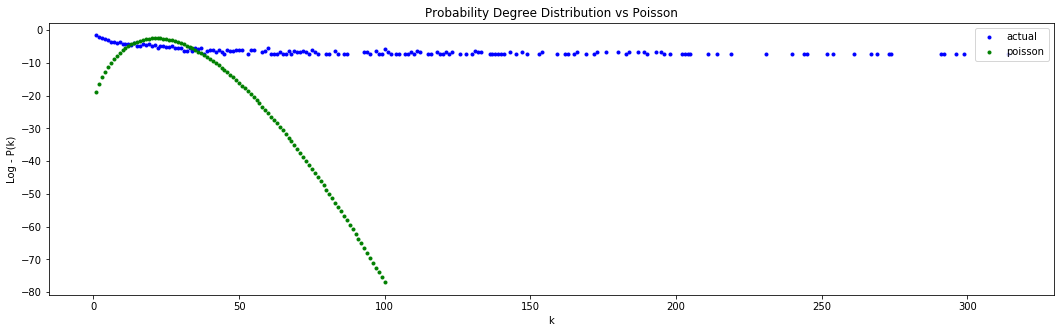

In [114]:
fig, ax = plt.subplots(figsize=(18,5))
plt.scatter(deg, np.log(cnt_prob), color='b', label = 'actual', marker = '.', linewidths = 1)
plt.scatter(deg_to_100, np.log(pois_prob), color = 'g', label = 'poisson', linewidths = 1, marker = '.')

plt.title("Probability Degree Distribution vs Poisson")
plt.ylabel("Log - P(k)")
plt.xlabel("k")
plt.legend(loc='upper right');
plt.show()

As expected, with many real life networks, it is evident that the degree distribution of the US flight network does not follow a random graph poisson distribution. The poisson grossly underestimates the number of nodes with small k and underestimates the long tail of nodes with large k. It also assumes the most common k is the average degree, 21, whereas in our network, the most common k is actually 1. 

As discussed previously, the network contains one highly connected central hub (a few highly connected airports). Random graphs as Erdos-Renyi modelled, represented by a poisson distribution, lack hubs - as k increases much higher than average k, k! will become much larger than <k>^k, thus making the probability of finding a node with large k infinitely small.

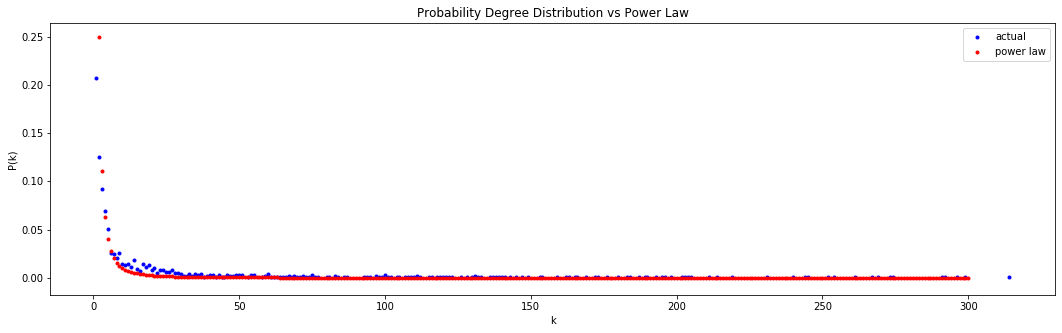

In [115]:
fig, ax = plt.subplots(figsize=(18,5))
plt.scatter(deg, cnt_prob, color='b', label = 'actual', marker = '.')
plt.scatter(deg_to_300, pow_law_prob, color = 'r', label = 'power law', marker = '.')

plt.title("Probability Degree Distribution vs Power Law")
plt.ylabel("P(k)")
plt.xlabel("k")
plt.legend(loc='upper right');
plt.show()

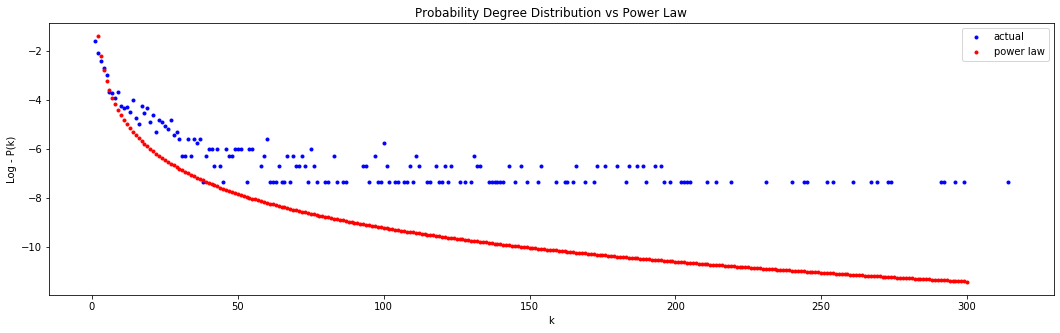

In [116]:
fig, ax = plt.subplots(figsize=(18,5))
plt.scatter(deg, np.log(cnt_prob), color='b', label = 'actual', marker = '.')
plt.scatter(deg_to_300, np.log(pow_law_prob), color = 'r', label = 'power law', marker = '.')

plt.title("Probability Degree Distribution vs Power Law")
plt.ylabel("Log - P(k)")
plt.xlabel("k")
plt.legend(loc='upper right');
plt.show()

Here we can see the degree distribution plotted with a power law distribution, where gamma = 2. We can see that the real life network resembles this model. As k increases, the probability of selecting a node with this degree decreases - it drops sharply at first with a small increase in k but there is a long tail with some nodes having a high degree.

This is reflective of a airline network where there are a few nodes which are highly connected, a few large airports with high traffic, and then many peripheral aiports which are connected to just a handful of other airports.   

### [PT - Additional part - not finished]

In [120]:
#Take logs of k degree
deg_log10 = []
for i in deg:
    deg_log10.append(m.log10(i))

#Take logs of y frequency
cnt_log10 = []
for i in cnt:
    cnt_log10.append(m.log10(i))
    
deg_log10_arr = np.array(deg_log10)
cnt_log10_arr = np.array(cnt_log10)

deg_log10_arr = deg_log10_arr.reshape(-1,1)
cnt_log10_arr = cnt_log10_arr.reshape(-1,1)

#Fit a linear regression
regressor = LinearRegression()  
reg1 = regressor.fit(deg_log10_arr, cnt_log10_arr)

#To find the parameters
gamma1 = reg1.coef_
#y-intercept
u1 = reg1.intercept_
#solve to find c
c1 = 10 **u1

In [121]:
print("gamma1 = {}".format(gamma1))
print("log(c1) = {}".format(u1))
print("c1 = {}".format(c1))


gamma1 = [[-1.04640166]]
log(c1) = [2.35266452]
c1 = [225.24985445]


In [122]:
powlaw1 = []
for i in deg:
    b = i**gamma1 * c1
    powlaw1.append(b)
    
powlaw1 = np.array(powlaw1).reshape(-1,1)

In [123]:
#extract nodes with k < 10^1.5
deg_exp = []
for i in deg_log10:
    if i < 1.5:
        deg_exp.append(i)
        
len(deg_exp)

31

In [124]:
cnt_exp = cnt_log10[-len(deg_exp):]

deg_exp_arr = np.array(deg_exp).reshape(-1,1)
cnt_exp_arr = np.array(cnt_exp).reshape(-1,1)

#Fit a linear regression for log(y) vs log(k) with k < 10^1.5
reg2 = regressor.fit(deg_exp_arr, cnt_exp_arr)

#To find the parameters
gamma2 = reg2.coef_
u2 = reg2.intercept_
c2 = 10 **u2

In [125]:
print("gamma2 = {}".format(gamma2))
print("log(c2) = {}".format(u2))
print("c2 = {}".format(c2))

gamma2 = [[-1.19363028]]
log(c2) = [2.64502388]
c2 = [441.59472552]


In [126]:
powlaw2 = []
for i in deg:
    b = i**gamma2 * c2
    powlaw2.append(b)
    
powlaw2 = np.array(powlaw2).reshape(-1,1)

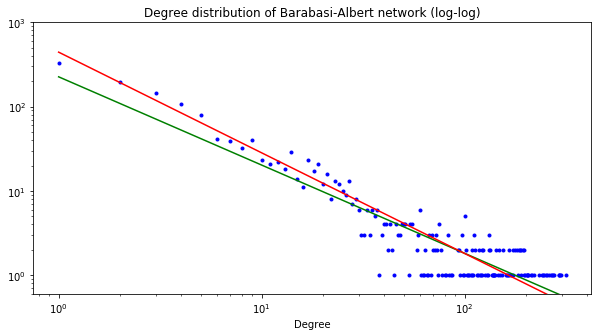

In [127]:
fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color='b', label = 'actual', marker = '.', linewidths = 1)
plt.plot(deg, powlaw1, color = 'g', label = 'Not good fit')
plt.plot(deg, powlaw2, color = 'r', label = 'Expected slope')
plt.xscale('log') 
plt.yscale('log')
#plt.xlim(0,10000)
plt.ylim(0.6,1000)
plt.xlabel("Frequency")
plt.xlabel("Degree")
plt.title("Degree distribution of Barabasi-Albert network (log-log)")
plt.show()

## CDF

/Users/pennytarling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


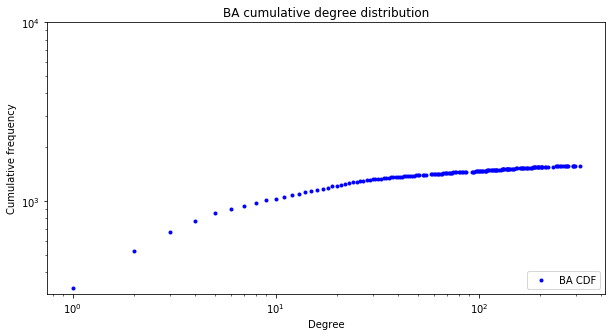

In [128]:
cnt_2 = []
for i in cnt:
    cnt_2.append(i)
    
cnt_2.reverse()

cnt_cdf = []
cnt_cdf.append(cnt_2[0])
cnt_3 = cnt_2[1:len(cnt_2)]
for i in range(len(cnt_3)):
    cnt_cdf.append(cnt_cdf[i] + cnt_3[i])
    
deg2 = []
for i in deg:
    deg2.append(i)
    
deg2.reverse()

fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg2, cnt_cdf, color='b', label = 'BA CDF', marker = '.', linewidths = 1)
#plt.plot(deg, norm_powlaw1, color = 'g')
#plt.plot(deg, norm_powlaw2, color = 'r')
#plt.plot(deg, powlaw4, color = 'g')
plt.xscale('log') 
plt.yscale('log')
plt.ylabel('Cumulative frequency')
plt.xlabel('Degree')
plt.legend(loc='lower right')
#plt.xlim(0,2000)
plt.ylim(0, 10000)
plt.title('BA cumulative degree distribution')
plt.show()

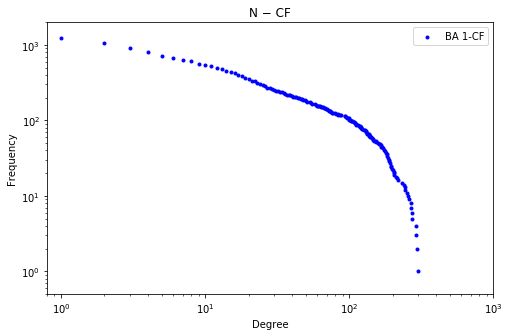

In [129]:
N = len(G)

cnt_N_minus_cdf = []
for i in cnt_cdf:
    cnt_N_minus_cdf.append(N-i)
    
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(deg2, cnt_N_minus_cdf, color='b', label = 'BA 1-CF', marker = '.', linewidths = 1)
#plt.plot(deg, powlaw1, color = 'g')
#plt.plot(deg, powlaw2, color = 'r')
#plt.plot(deg, powlaw4, color = 'g')
plt.xscale('log') 
plt.yscale('log')
plt.title('N − CF')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.xlim(0.8,1000)
plt.ylim(0.5, 2000)
plt.show()

In [130]:
cnt_N_minus_cdf

cnt_N_minus_cdf_log = []
for i in cnt_N_minus_cdf[0:(len(cnt_N_minus_cdf)-1)]:
    cnt_N_minus_cdf_log.append(m.log10(i))

cnt_N_minus_cdf_log.reverse()  

deg_log10_arr2 = deg_log10_arr[0:len(cnt_N_minus_cdf_log)]
cnt_N_minus_cdf_log_arr = np.array(cnt_N_minus_cdf_log).reshape(-1,1)

reg5 = regressor.fit(deg_log10_arr2, cnt_N_minus_cdf_log_arr)

In [131]:
#To find the parameters
gamma5 = reg5.coef_
u5 = reg5.intercept_
c5 = 10 **u5

In [132]:
print("gamma5 = {}".format(gamma5))
print("log(c5) = {}".format(u5))
print("c5 = {}".format(c5))

gamma5 = [[-1.10082019]]
log(c5) = [4.02756471]
c5 = [10655.27611539]


In [133]:
powlaw5 = []
for i in deg2:
    b = i**gamma5 * c5
    powlaw5.append(b)

In [134]:
powlaw5 = np.array(powlaw5).reshape(-1,1)

In [135]:
deg_log10_2 = deg_log10[:]
deg_log10_2.reverse()

In [136]:
deg_log10_2 = deg_log10_2[0:50]
cnt_N_minus_cdf_log_2 = cnt_N_minus_cdf_log[:]

cnt_N_minus_cdf_log_2.reverse()

cnt_N_minus_cdf_log_2 = cnt_N_minus_cdf_log_2[0:50]

deg_log10_2 = np.array(deg_log10_2).reshape(-1,1)
cnt_N_minus_cdf_log_2 = np.array(cnt_N_minus_cdf_log_2).reshape(-1,1)

In [137]:
reg6 = regressor.fit(deg_log10_2, cnt_N_minus_cdf_log_2)

In [138]:
#To find the parameters
gamma6 = reg6.coef_
u6 = reg6.intercept_
c6 = 10 **u6

In [139]:
print("gamma6 = {}".format(gamma6))
print("log(c6) = {}".format(u6))
print("c6 = {}".format(c6))

gamma6 = [[-0.56228691]]
log(c6) = [3.24794068]
c6 = [1769.86720865]


In [140]:
powlaw6 = []
for i in deg2:
    b = i**gamma6 * c6
    powlaw6.append(b)

In [141]:
powlaw6 = np.array(powlaw6).reshape(-1,1)

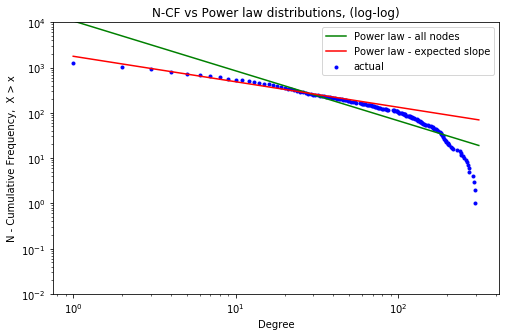

In [142]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(deg2, cnt_N_minus_cdf, color='b', label = 'actual', marker = '.', linewidths = 1)
plt.plot(deg2, powlaw5, color = 'g', label = "Power law - all nodes")
plt.plot(deg2, powlaw6, color = 'r', label = "Power law - expected slope")
#plt.plot(deg, powlaw4, color = 'g')
plt.xscale('log') 
plt.yscale('log')
plt.title("N-CF vs Power law distributions, (log-log)")
plt.ylabel("N - Cumulative Frequency,  X > x")
plt.xlabel("Degree")
plt.legend(loc='upper right')
#plt.xlim(0,10000)
plt.ylim(0.01, 10000)
plt.show()

[PT - Doesn't really work!]

###  Erdös-Rényi, Watts-Strogatz Small-World and Barabási-Albert (preferential attachment) Models



In [109]:
def gnp_random_graph(N, p):
    G_1 = nx.Graph()
    G_1.add_nodes_from(range(N))
    
    for i, j in itertools.combinations(G_1.nodes(), 2):
        r = random.random()
        if r < p:
            G_1.add_edge(i, j)
        # Do nothing if r >= p
        
    return G_1

In [110]:
G_1 = gnp_random_graph(50, 0.1)
#nx.draw(G_1)
#print('Graph has', G_1.number_of_edges(), 'edges.')

In [111]:
def gnm_random_graph(N, M):
    G_2 = nx.Graph()
    G_2.add_nodes_from(range(N))
    
    possible_edges = itertools.combinations(G_2.nodes(), 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G_2.add_edges_from(edges_to_add)
    
    return G_2

In [112]:
G_2 = gnm_random_graph(1572, 17241)
#nx.draw(G_2)

In [113]:
degrees_2 = dict(G_2.degree()).values() # degree returns a view object DegreeView  

In [114]:
def watts_strogatz_graph(N, k, p):
    # 1. Create a ring of N nodes
    G_3 = nx.cycle_graph(N)

    # 2. Connect each node n to k nearest neighbors
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G_3.nodes():
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G_3.add_edge(n, left)
            G_3.add_edge(n, right)
    
    # 3. Rewire edges with probability p
    for u, v in list(G_3.edges()):
        if random.random() < p:
            not_neighbors = set(G_3.nodes()) - set(G_3.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G_3.remove_edge(u, v)
            G_3.add_edge(u, w)

    return G_3

In [115]:
G_3 = watts_strogatz_graph(1572, 21, 0.2)

Test similarity of average shortest path with different values of k:

In [116]:
nx.average_shortest_path_length(G_3)

3.134755581038641

In [117]:
degrees_3 = dict(G_3.degree()).values() # degree returns a view object DegreeView  

In [118]:
G_4 = nx.barabasi_albert_graph(1572, 10)

In [120]:
degrees_4 = dict(G_4.degree()).values() # degree returns a view object DegreeView  

Test similarity of total network degree with different values of m:

In [121]:
sum(degree_sequence)

34428

In [122]:
sum(degrees_4)

31240

In [123]:
G_5=nx.powerlaw_cluster_graph(1572,m=10,p=0.38414)
degrees_5 = dict(G_5.degree()).values()

In [124]:
nx.average_shortest_path_length(G_5)

2.6104545977262825

In [125]:
sum(degrees_5)

31120

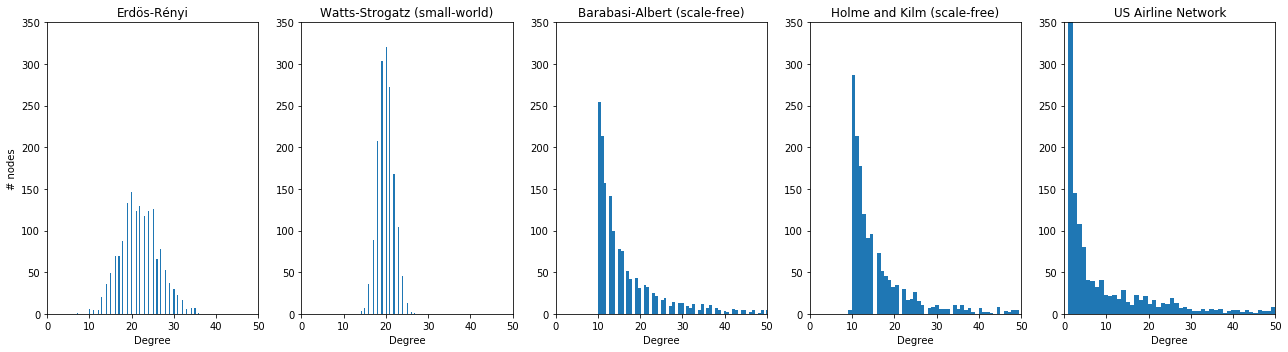

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18,5))
ax0, ax1, ax2, ax5, ax3  = axes.flatten()

ax0.hist(list(degrees_2), 100)
ax0.set_title('Erdös-Rényi')
ax0.set_ylim([0, 350])
ax0.set_xlim([0,50])
ax0.set_xlabel('Degree')
ax0.set_ylabel('# nodes')

ax1.hist(list(degrees_3), 50)
ax1.set_title('Watts-Strogatz (small-world)')
ax1.set_ylim([0, 350])
ax1.set_xlim([0,50])
ax1.set_xlabel('Degree')

ax2.hist(list(degrees_4), 300)
ax2.set_title('Barabasi-Albert (scale-free)')
ax2.set_ylim([0, 350])
ax2.set_xlim([0,50])
ax2.set_xlabel('Degree')

ax5.hist(list(degrees_5), 300)
ax5.set_title('Holme and Kilm (scale-free)')
ax5.set_ylim([0, 350])
ax5.set_xlim([0,50])
ax5.set_xlabel('Degree')

ax3.hist(degree_sequence, 300)
ax3.set_title('US Airline Network')
ax3.set_ylim([0, 350])
ax3.set_xlim([0,50])
ax3.set_xlabel('Degree')


fig.tight_layout()
plt.show()

Generated 3 graphs using the below models setting the number of nodes = 1572, the number of nodes in US airline network

#### Erdös-Rényi (Nodes = 1572, Edges = 17,214)
Set the number of edges = 17,214, the same  US Airline Network. The Erdos-Renyi algorithm  follows a poisson distribution so as discussed above, this does not resemble the real life airline network

#### Watts-Strogatz Small-World Model (Nodes = 1572, k = 21, p = 0.2)
We experimented with different values of k nearest neighbours. This graph shows, k = 21 which is the average degree of airline network. This k results in an average shortest path length = 3.13, which is close to actual shortest path length = 3.12. Even though this feature is similar, the degree distribution is again very different, with most nodes being of average degree and few nodes having small or large degrees

#### Barabasi-Albert (Nodes = 1572, m = 10)
We experimented with different m, number of starting nodes. This graph shows m = 10 and results in a total degree of 31,240 which is close to the total degree of actual network, 34,428. The B-A model follows a power law distribution which as discussed above more closely resembles the real life network. However it underestimates the volume of nodes with degree of just 1 and how sharply this decreases as k increases. 

#### Holme and Kim (Nodes = 1572, m = 1, p=0.2)
We experimented with different p, number of starting nodes. This graph shows m = 1 and 1572 nodes. The H-K model is basically the B-A model with an extra step that makes that each random edge is followed by a chance of making an edge to one of its neighbors too (and thus a triangle). However it underestimates the volume of nodes with degree of just 1 and how sharply this decreases as k increases. 


In [127]:
G_6 = nx.barabasi_albert_graph(1572, 1)
degrees_6 = dict(G_6.degree()).values()
G_7=nx.powerlaw_cluster_graph(1572,m=1,p=0.38414)
degrees_7 = dict(G_7.degree()).values()

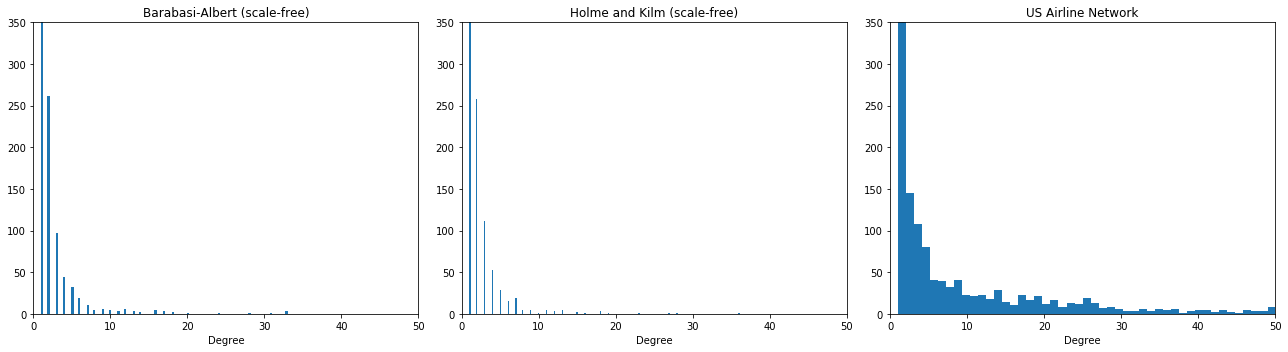

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
ax6, ax7, ax3  = axes.flatten()

ax6.hist(list(degrees_6), 300)
ax6.set_title('Barabasi-Albert (scale-free)')
ax6.set_ylim([0, 350])
ax6.set_xlim([0,50])
ax6.set_xlabel('Degree')

ax7.hist(list(degrees_7), 300)
ax7.set_title('Holme and Kilm (scale-free)')
ax7.set_ylim([0, 350])
ax7.set_xlim([0,50])
ax7.set_xlabel('Degree')

ax3.hist(degree_sequence, 300)
ax3.set_title('US Airline Network')
ax3.set_ylim([0, 350])
ax3.set_xlim([0,50])
ax3.set_xlabel('Degree')


fig.tight_layout()
plt.show()

If we change the number of starting nodes to 1 we get the volume of nodes with degree near to 1 similar to the US Airline Newtwork but the differences sharply increase as k increases, and the total degree of the model is much lower than the real life network.

In [129]:
print("Average clustering coefficient")
print("")
print("US Airline Network ",nx.average_clustering(G))
print("Erdös-Rényi ",nx.average_clustering(G_2))

print("Watts-Strogatz (small-world) ",nx.average_clustering(G_3))
print("Barabasi-Albert (scale-free) ",nx.average_clustering(G_4))
print("Holme and Kilm (scale-free) {:.10f}".format(nx.average_clustering(G_7)))


Average clustering coefficient

US Airline Network  0.5047939546538639
Erdös-Rényi  0.013344154395216561
Watts-Strogatz (small-world)  0.37248922534790135
Barabasi-Albert (scale-free)  0.044701446990348774
Holme and Kilm (scale-free) 0.0000000000


# 5. COMMUNITIES


1st part: 27/03 - 02/04

In [143]:
MOD = nx.modularity_matrix(G)

In [152]:
import community.community_louvain

In [153]:
#first compute the best partition
partition = community.community_louvain.best_partition(G)
ax=community.community_louvain.induced_graph(partition, G)
num_part=ax.number_of_nodes()

C:\Users\alex1\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


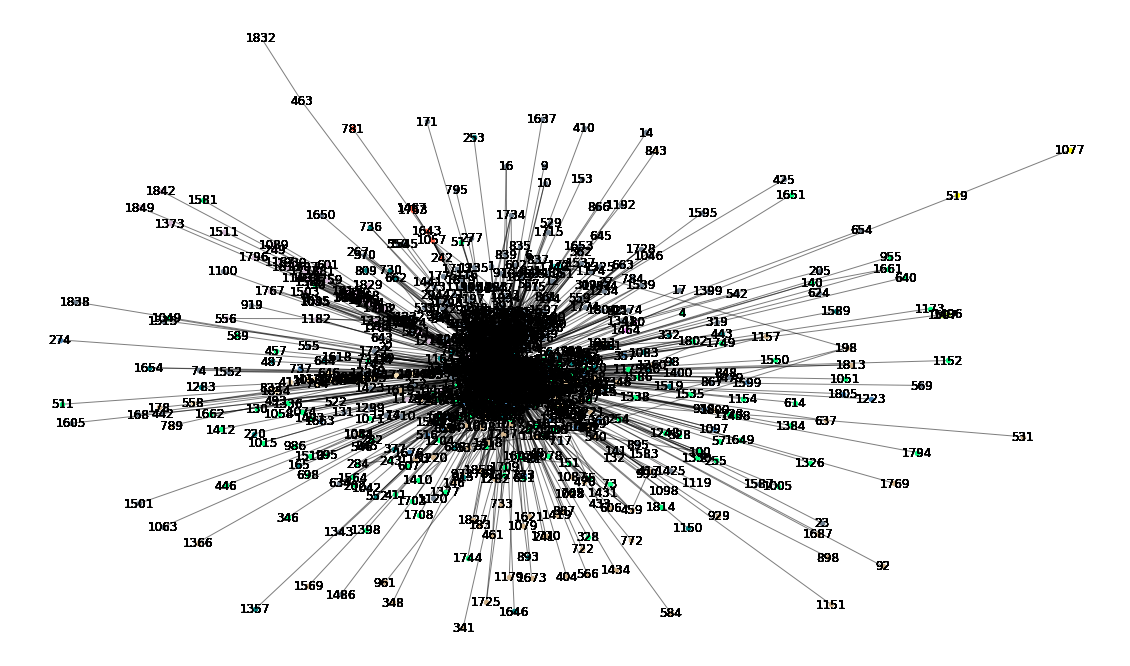

In [154]:
plt.figure(figsize=(20,12))
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
plt.axis("off")
cols=list(mcolors.CSS4_COLORS.values())[-num_part:]
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = cols[count])
    nx.draw_networkx_labels(G,pos)
    count = count + 1
nx.draw_networkx_edges(G, pos, alpha=0.5, withd=1)
plt.show()

In [140]:
print("Number of Communities found by algorithm: ", max(list(partition.values())))

Number of Communities found by algorithm:  11


In [141]:
MOD = community.community_louvain.modularity(partition, G)

In [142]:
MOD

0.269820303799027

# 6. DYNAMICS

We are going to use the model SIR to simulate the spreading of a disease over the US Airports Dataset. That is the spread of a virus on airports all over the world connected by flights to the US.

In [9]:
import EoN

In [5]:
tmax = 50
iterations = 2 #run 5 simulations
tau = 0.05 #transmission rate
gamma = [0,0.05,0.1,0.5] #recovery rate
rho = 0.1 #random fraction initially infected

In [6]:
import seaborn as sns
sns.set_style('darkgrid')

We show the % of "infected" airports trying with different values of the recovery rate.

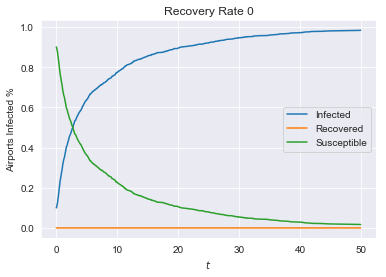

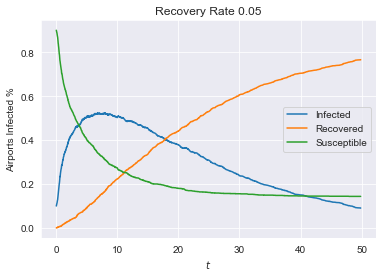

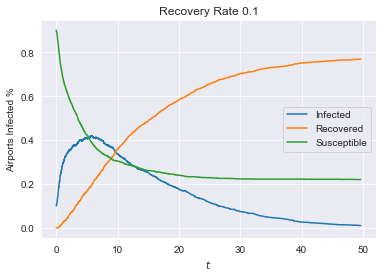

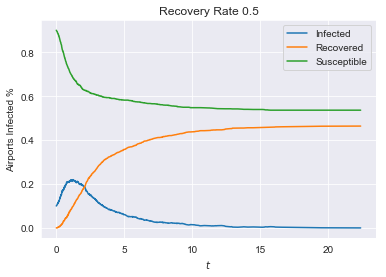

In [9]:
for gam in gamma:
    plt.figure(figsize=(6,4))
    t, S, I, R = EoN.fast_SIR(G, tau, gam, rho=rho, tmax = tmax)
    sns.lineplot(t, I/len(G), label='Infected')
    sns.lineplot(t, R/len(G), label='Recovered')
    sns.lineplot(t,S/len(G), label='Susceptible')
    plt.ylabel('Airports Infected %')
    plt.xlabel('$t$')
    plt.title('Recovery Rate {}'.format(gam))
    plt.legend()
    plt.show()

## Dynamics and transition tree for a SIR disease

We can show the evolution of the disease though the network at different points in time.

Doing Gillespie simulation
done with simulation, now plotting


C:\Users\alex1\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


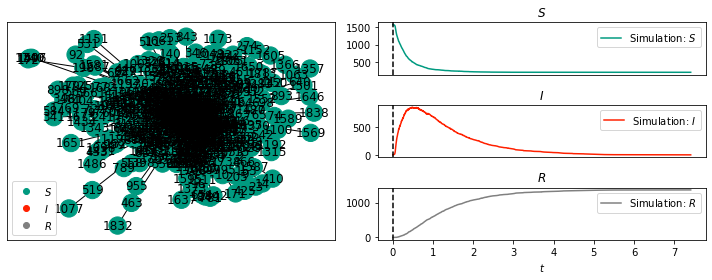

In [37]:

print('Doing Gillespie simulation')
sim = EoN.Gillespie_SIR(G, 1, 1, return_full_data=True)
print('done with simulation, now plotting')
nx_kwargs = {"with_labels":True}
ani = sim.animate(**nx_kwargs) #plot at time 1.
plt.show()


In [11]:
import matplotlib

In [38]:
plt.rcParams['animation.ffmpeg_path'] =r'C:\Users\alex1\Downloads\ffmpeg-20200519-74dfc88-win64-static\ffmpeg-20200519-74dfc88-win64-static\bin\ffmpeg.exe'
plt.rcParams['figure.figsize'] = [12,8]
FFwriter=matplotlib.animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
ani.save('SIRV_animate_US.mp4', writer=FFwriter)


In [36]:
type(ani)

matplotlib.animation.FuncAnimation

This can be better observed with a transimission tree with the airport codes on it:

C:\Users\alex1\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\alex1\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


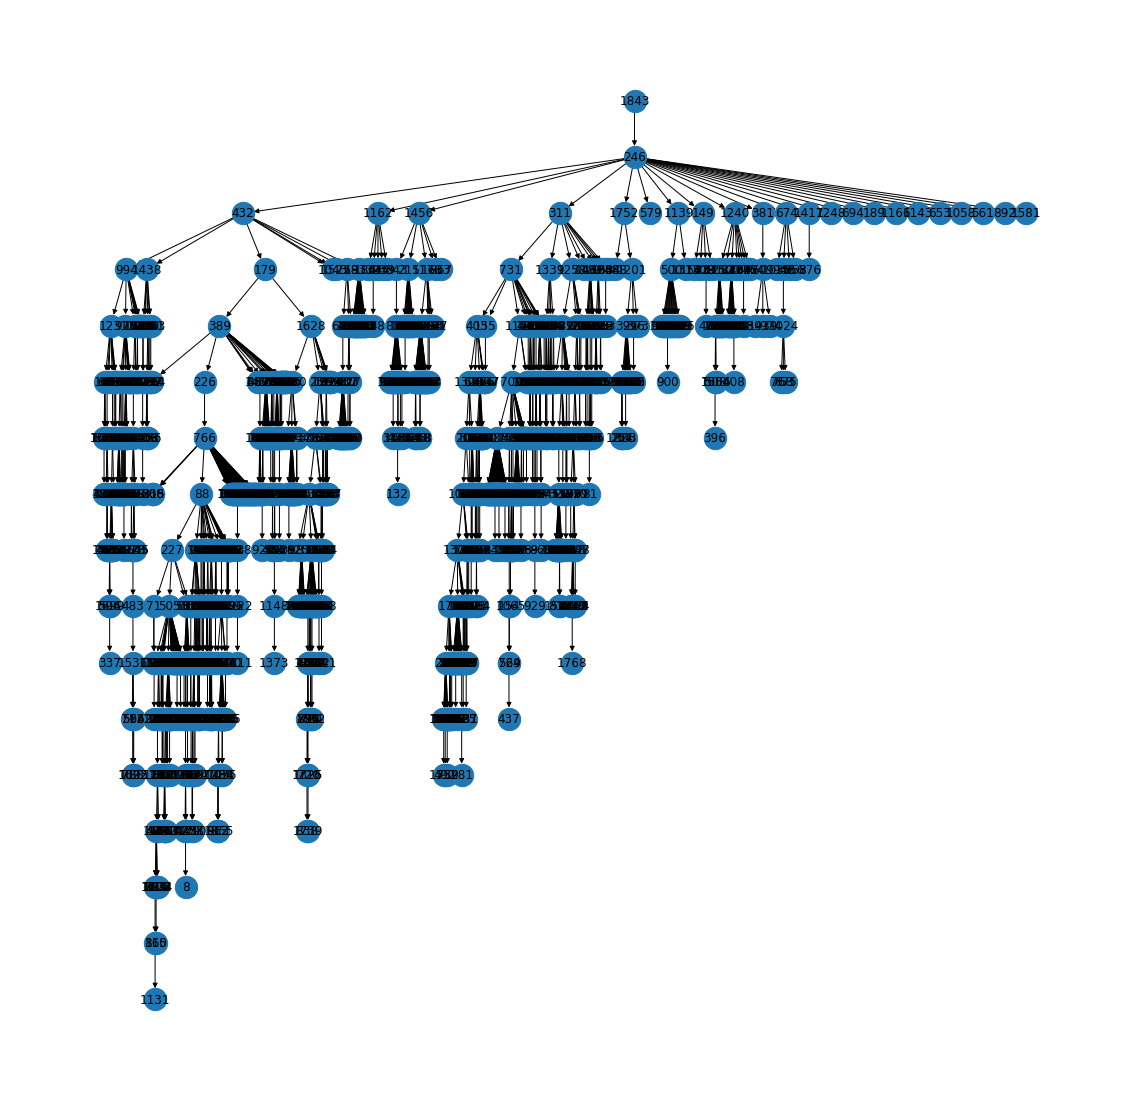

In [15]:
T = sim.transmission_tree() #A networkx DiGraph with the transmission tree
Tpos = EoN.hierarchy_pos(T) #pos for a networkx plot
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
nx.draw(T, Tpos, ax=ax, node_size = 500, with_labels=True)
plt.show()


According to the transmision tree, given a start of the transmission on the 938 airport, Mason City Municipal Airport, Iowa, it would spread to the Eastern Iowa Aiport, Iowa, and then it will spread across airports of different states:

- 391, Dallas Forth worth, Dallas
- 685, Westchester County, New York.
- 476, Elmira / Corning, New York.
- 134, Kalamazoo / Battle Creek, Miguigan.
- 296 Charleston International Airport, South Carolina.

And to some isolated airports, that are infected on the first stages but do not propagate the disease further as:

- 1823, Manokotak Airport, Alaska.
- 1019, Delaware County Ariport, Delaware.


## Dynamics on a Grid Graph

In [16]:
tmax = 10
iterations = 5 #run 5 simulations
tau = 0.5 #transmission rate
gamma = 0.5 #recovery rate
rho = 0.005 #random fraction initially infected

C:\Users\alex1\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado

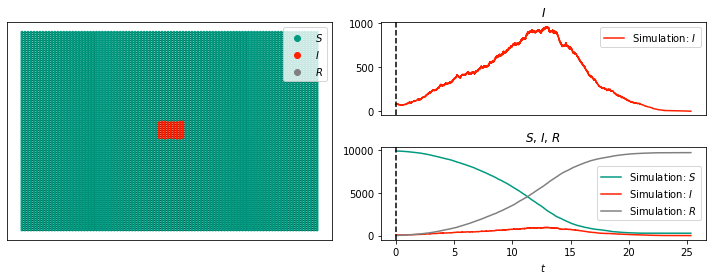

In [19]:
G2 = nx.grid_2d_graph(100,100) #each node is (u,v) where 0<=u,v<=99
#we'll initially infect those near the middle
initial_infections = [(u,v) for (u,v) in G2 if 45<u<55 and 45<v<55]
pos = {node:node for node in G2}
sim_kwargs = {'pos': pos}
sim = EoN.fast_SIR(G2, 2.0, 1.0, initial_infecteds = initial_infections,
tmax = 40, return_full_data=True, sim_kwargs = sim_kwargs)
ani=sim.animate(ts_plots=['I', 'SIR'], node_size = 4)
ani.save('SIRV_animate_grid_graph_US.mp4', writer=FFwriter)

In [64]:
def visual_dict(dictionary, label):
    dict2=dict(Counter(dictionary))
    dict2df=pd.DataFrame(dict2.values(), index=dict2.keys(), columns = [label])
    return dict2df.sort_values(by=label, ascending=False).head(5)

# EXPERIMENTING WITH OTHER NETWORK

## COMMUNITIES

### Karate Club dataset

In [149]:
G_KC = nx.karate_club_graph()

partition = community.community_louvain.best_partition(G_KC)
ax=community.community_louvain.induced_graph(partition, G_KC)
num_part=ax.number_of_nodes()
plt.figure(figsize=(15,8))
#drawinG_KC
size = float(len(set(partition.values())))
pos = nx.spring_layout(G_KC)
count = 0
plt.axis("off")
cols=list(mcolors.CSS4_COLORS.values())[-num_part:]
for com in set(partition.values()) :
    
    list_nodes = [nodes for nodes in partition.keys()
                                 if partition[nodes] == com]
    
    nx.draw_networkx_nodes(G_KC, pos, list_nodes, node_size = 300,
                                node_color = cols[count])
    nx.draw_networkx_labels(G_KC,pos)
    
    count += 1
    
nx.draw_networkx_edges(G_KC, pos, alpha=0.5, withd=1)
plt.show()

AttributeError: module 'community' has no attribute 'community_louvain'

### Kanye West Network

In [ ]:
import json
from networkx.readwrite import json_graph

In [ ]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

kw=read_json_file('164f0d73-1234-4e2c-8743-d77bf2191051-collaboration-graph.json')

In [ ]:
G_KC = kw

partition = community.community_louvain.best_partition(G_KC)
ax=community.community_louvain.induced_graph(partition,G_KC)
num_part=ax.number_of_nodes()
plt.figure(figsize=(15,8))
#drawinG_KC
size = float(len(set(partition.values())))
pos = nx.spring_layout(G_KC)
count = 0
plt.axis("off")
cols=list(mcolors.CSS4_COLORS.values())[-num_part:]
for com in set(partition.values()) :
    
    list_nodes = [nodes for nodes in partition.keys()
                                 if partition[nodes] == com]
    
    nx.draw_networkx_nodes(G_KC, pos, list_nodes, node_size = 300,
                                node_color = cols[count])
    nx.draw_networkx_labels(G_KC,pos)
    count += 1
    
nx.draw_networkx_edges(G_KC, pos, alpha=0.5, withd=1)
plt.show()

In [ ]:
num_part

### Observable

Link to Observable: https://observablehq.com/d/3b0055a0137faa95